# Data Loading

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
np.random.seed(0)

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from torch import nn
import torch.nn.functional as F

from einops import rearrange
#from torchsummary import summary

import sys
sys.path.insert(0, '../helpers')
# sys.path.insert(0,'/home/labs/rudich/sagima/helpers')
from plotting import *
from validate import *
from models import *
from data_handlers import *
from training import *
from metrics import *
from explore import *
from torchsummary import *
from visual_helpers_2 import *

#from visual_helpers import *

import itertools



#taken from the model building section - 
import pandas as pd
pd.set_option('max_colwidth', 800)


import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
import xgboost as xg
import torch.optim as optim
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.fft import fft, fftfreq
import folium

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
import cartopy.feature


import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import json

import ast
from scipy.spatial.distance import cdist

from sklearn.metrics import precision_recall_fscore_support
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary
from tqdm import tqdm


/home/labs/rudich/sagima/.conda/envs/sagi_base/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/labs/rudich/sagima/.conda/envs/sagi_base/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZNK3c107SymBool10guard_boolEPKcl'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
def convert_string_to_tuple_list(string_list):
    tuple_list = []
    for string in string_list:
        # Remove leading and trailing whitespace and parentheses
        string = string.strip('()')
        # Convert string to tuple using ast.literal_eval
        tuple_value = ast.literal_eval(string)
        tuple_list.append(tuple_value)
    return tuple_list

def remove_non_label(tensor):

    channel_2_values = tensor[:, 1]
    reshape = channel_2_values.view(channel_2_values.shape[0], -1)
    nan_mask = torch.isnan(reshape).all(dim=1)
    tensor_data = tensor[~nan_mask]
    return tensor_data

def replace_keys_with_sequential_integers(dictionary):
    new_dict = {}
    keys = list(dictionary.keys())
    for i in range(len(keys)):
        new_dict[i] = dictionary[keys[i]]
    return new_dict

In [4]:
def get_cams_forecast_pred(stations,meta_data=None,tensor_data=None,load_tensor_forecast_pm10=False):
    #caculate the distance for each station and see the cordinats 
    #then we will take the cordinates that is best for each station
    #then for each station with the right cordinates and for each day and leadtime we will return the pm
    if load_tensor_forecast_pm10==True:
        data_pm10=torch.load("/home/labs/rudich/gavriel/pm_10/data_pm10.pkl")
        meta_data=torch.load("/home/labs/rudich/gavriel/pm_10/meta_data.pkl")
    num_dates=len(meta_data['timestamp'])
    num_dates=len(meta_data['lead_time'])
    list_pm=[]
    lat_lon_station={}
    meta_data_pm={}
    tensor_lat=torch.tensor(meta_data['latitude'].values)
    tensor_lon=torch.tensor(meta_data['longitude'].values)
    #implement without the matrix
    for i in range(len(station)):
        station_id=torch.tensor(station['stn_id'].loc[i])
        lat=torch.tensor(station['lat'].loc[i])
        lon=torch.tensor(station['lon'].loc[i])
        min_lat=torch.argmin(abs(tensor_lat-lat)).item()
        min_lon=torch.argmin(abs(tensor_lon-lon)).item()
        lat_lon_station[i]=[min_lat,min_lon]

    #THEN:
    for i in range((len(station))):
        list_pm.append(tensor_data[:,:,lat_lon_station[i][0],lat_lon_station[i][1]])
    tensor3d_pm=torch.stack(list_pm)
#meta_data
    #creating the pd.DatetimeIndex(, tz="UTC")
    files=os.listdir("/home/labs/rudich/gavriel/pm_10/download_2018-07-18.netcdf")
    date_pd=[]
    dir1="/home/labs/rudich/gavriel/pm_10/download_2018-07-18.netcdf"
    for i,file in enumerate(files):
        dir=dir1+"/"+file
        data=xr.open_dataset(dir)
        for x in data.time:
            date_pd.append(pd.to_datetime(x.values, format='%Y-%m-%d %H:%M:%s'))
    date_pd=dt_index = pd.DatetimeIndex(date_pd, tz="UTC")
    date_pd 

    #META_DATA:
    data = xr.open_dataset("/home/labs/rudich/gavriel/pm_10/download_2018-07-18.netcdf/date_2018-07-18_time_00_00_00.nc")
    meta_data_pm["lead_time"]=[x for x in range(109) if x%3==0]
    meta_data_pm["latitude"]=data["latitude"].values
    meta_data_pm["longitude"]=data['longitude'].values
    meta_data_pm["station_lan_lon"]=lat_lon_station
    meta_data_pm["station_id_name"]=station['stn_name']
    meta_data_pm["timestamp"]=date_pd
    
    return tensor3d_pm,meta_data_pm


In [5]:
with open('new_lats_dict.json') as json_file:
    new_lats_dict = json.load(json_file)
inv_lats_dict = {value : int(key) for key, value in new_lats_dict.items()}  
with open('new_lons_dict.json') as json_file:
    new_lons_dict = json.load(json_file)
inv_lons_dict = {value : int(key) for key, value in new_lons_dict.items()}  
with open('pixel_to_station_id.pkl', 'rb') as f:
    lat_lon_to_station_id = pickle.load(f)
    
with open("saved_turkey_lat_lon_cords", "rb") as fp:   # Unpickling
    saved_turkey_lat_lon_cords = pickle.load(fp)

with open("saved_turkey_lat_lon_idx", "rb") as fp:   # Unpickling
    saved_turkey_lat_lon_idx = pickle.load(fp)
    
with open("saved_greece_lat_lon_cords", "rb") as fp:   # Unpickling
    saved_greece_lat_lon_cords= pickle.load(fp)

with open("saved_greece_lat_lon_idx", "rb") as fp:   # Unpickling
    saved_greece_lat_lon_idx = pickle.load(fp)
    
saved_turkey_lat_lon_cords = convert_string_to_tuple_list(saved_turkey_lat_lon_cords)
saved_turkey_lat_lon_cords.append((35.0,27.0))
saved_turkey_lat_lon_cords.append((35.0, 45.5))


with open("saved_turkey_and_greece_lat_lon_cords", "rb") as fp:   # Unpickling
    saved_turkey_and_greece_lat_lon_cords= pickle.load(fp)

with open("saved_turkey_and_greece_lat_lon_idx", "rb") as fp:   # Unpickling
    saved_turkey_and_greece_lat_lon_idx = pickle.load(fp)


In [6]:
def check_timestamps(timestamps):
    for i in range(len(timestamps) - 1):
        current_timestamp = timestamps[i]
        next_timestamp = timestamps[i + 1]
        time_difference = current_timestamp  - next_timestamp

        if time_difference != np.timedelta64(3, 'h'):
            return False
    
    return True

In [7]:
def update_dict_keys(dict_to_update, lat_dict, lon_dict):
    updated_dict = {}

    min_lat, max_lat = min(lat_dict), max(lat_dict)
    min_lon, max_lon = min(lon_dict), max(lon_dict)

    for key, value in dict_to_update.items():
        lat_lon = key.strip('[]').split()
        lat = float(lat_lon[0])
        lon = float(lat_lon[1])

        if lat < min_lat or lat > max_lat or lon < min_lon or lon > max_lon:
            continue

        new_lat = lat_dict.get(lat, lat)
        new_lon = lon_dict.get(lon, lon)

        new_key = f'[{new_lat} {new_lon}]'
        updated_dict[new_key] = value

    return updated_dict

from itertools import islice
sliced_dict = dict(islice(inv_lons_dict.items(), 15))
tensor_ids_stations_dict = update_dict_keys(lat_lon_to_station_id,inv_lats_dict,sliced_dict)

In [8]:
colab_dir = "/home/labs/rudich/Collaboration/dust_prediction/data"
meteo_dir = colab_dir+"/interpolated_mean_normalized/"
meteo_de_dir = colab_dir+"/meteorology_renormalization_tensors"
dust_dir = colab_dir+"/dust_61368_108_2_339/"

meteo_meta = torch.load(meteo_dir+"/meteorology_tensor_62_81_189_metadata.pkl")
dust_meta = torch.load(dust_dir+"/dust_61368_108_2_339_metadata.pkl")

lons_dict = meteo_meta['dims']['lons']
lats_dict = meteo_meta['dims']['lats']
inv_lats_dict = {value : int(key) for key, value in lats_dict.items()}
inv_lons_dict = {value : int(key) for key, value in lons_dict.items()} 

# lat_start, lat_end = 40, 75
# lon_start, lon_end = 80, 117
# lat_start, lat_end = 10, 75
# lon_start, lon_end = 50, 117
lat_start, lat_end = 10, 75
lon_start, lon_end = 50, 117
new_lats_dict = {i: lats_dict[i] for i in range(lat_start, lat_end)}
new_lons_dict = {i: lons_dict[i] for i in range(lon_start, lon_end)}

def replace_keys_with_sequential_integers(dictionary):
    new_dict = {}
    keys = list(dictionary.keys())
    for i in range(len(keys)):
        new_dict[i] = dictionary[keys[i]]
    return new_dict

new_lats_dict = replace_keys_with_sequential_integers(new_lats_dict)
inv_dict_lats = {v:k for k, v in new_lats_dict.items()}
new_lons_dict = replace_keys_with_sequential_integers(new_lons_dict)
inv_dict_lons = {v:k for k, v in new_lons_dict.items()}

In [9]:
new_corrected = np.load('delta_new_model_.npy')

In [12]:
df['delta']= new_corrected

In [15]:
df['pm10_corrected'] = df.pm10 + df.delta

In [10]:
df = pd.read_parquet('extened_test_small_ndvi.parquet_before_ndvi.gzip')

In [16]:
display(df.head())
display(df.tail())

,time,lat_lon_coord,delta,pm10,stn_mesm,pm10_corrected
0,2003-01-01 00:00:00+00:00,"(15.0, -7.0)",-7.954271,70.524266,NaN,62.569995
1,2003-01-01 03:00:00+00:00,"(15.0, -7.0)",12.434012,90.199691,NaN,102.633704
2,2003-01-01 06:00:00+00:00,"(15.0, -7.0)",1.515370,109.875110,NaN,111.390480
3,2003-01-01 09:00:00+00:00,"(15.0, -7.0)",-22.457926,80.513715,NaN,58.055789
4,2003-01-01 12:00:00+00:00,"(15.0, -7.0)",23.226229,51.152313,NaN,74.378541


,time,lat_lon_coord,delta,pm10,stn_mesm,pm10_corrected
228698465,2020-12-31 09:00:00+00:00,"(47.0, 26.0)",10.405501,5.632606,NaN,16.038108
228698466,2020-12-31 12:00:00+00:00,"(47.0, 26.0)",14.606208,2.253301,NaN,16.859509
228698467,2020-12-31 15:00:00+00:00,"(47.0, 26.0)",10.904622,3.152334,NaN,14.056956
228698468,2020-12-31 18:00:00+00:00,"(47.0, 26.0)",7.414813,4.051367,NaN,11.466179
228698469,2020-12-31 21:00:00+00:00,"(47.0, 26.0)",3.937818,2.676739,NaN,6.614558


In [11]:
df = df.assign(lat_lon_coord = convert_string_to_tuple_list(df.lat_lon_coord.values.tolist()))

In [26]:
df2['pm10'] = df2['pm10'] * (10**9)

In [12]:
df.head()

,time,lat_lon_coord,delta,pm10,stn_mesm
0,2003-01-01 00:00:00+00:00,"(15.0, -7.0)",1.047821,70.524266,NaN
1,2003-01-01 03:00:00+00:00,"(15.0, -7.0)",21.225750,90.199691,NaN
2,2003-01-01 06:00:00+00:00,"(15.0, -7.0)",32.248775,109.875110,NaN
3,2003-01-01 09:00:00+00:00,"(15.0, -7.0)",37.717949,80.513715,NaN
4,2003-01-01 12:00:00+00:00,"(15.0, -7.0)",36.743103,51.152313,NaN


In [29]:
df = (df2
      .pipe(lambda d: d.assign(lat_lon_coord = convert_string_to_tuple_list(d['lat_lon_coord'].values.tolist())))
     )

In [11]:
                
# df = (#pd.read_csv('test_df.csv')
#       pd.read_csv('extened_test_small.csv')
# #       pd.read_parquet('extened_test_small_ndvi.parquet_before_ndvi.gzip')
#       .pipe(lambda d: d.assign(lat_lon_coord = convert_string_to_tuple_list(d['lat_lon_coord'].values.tolist())))
#      )



In [30]:
del df2

In [13]:
df[['lat', 'lon']] = pd.DataFrame(df['lat_lon_coord'].tolist(), index=df.index)

df = (df
      .assign(lat_index = df.lat.map(inv_dict_lats),
              lon_index = df.lon.map(inv_dict_lons),
              pm10_corrected = df.pm10 + df.delta
              )
     )

In [ ]:
df.tail()

In [35]:
df.to_parquet('df_checking_corr.gzip',
              compression='gzip')  

In [2]:
df = pd.read_parquet('df_checking_corr.gzip')
df['pm10_corrected'] = df['pm10_corrected'].clip(lower=0)

In [22]:
# df_pm = pd.read_csv('df_pm_all.csv',index_col=0)
# df_cord = pd.read_csv("/home/labs/rudich/sagima/TOAR/coordinates_pm.csv")
# df_cord = df_cord.rename(columns={df_cord.columns[0]:'station_id'})
# df_cord = (df_cord 
#                        .rename(columns={'lng':'lon'})
#                        .assign(stn_id=np.arange(0,df_cord.shape[0],1))
#                         )


In [9]:
# def flatten_list(lst):
#     flattened = []
#     for item in lst:
#         if isinstance(item, list):
#             flattened.extend(flatten_list(item))
#         else:
#             flattened.append(item)
#     return flattened


# list_of_stations = sorted(flatten_list(list(tensor_ids_stations_dict.values())))
# list_of_stations = [str(x) for x in list_of_stations]
# a = (df_pm[list_of_stations]
#      .reset_index()
#      .pipe(lambda d:d.assign(time=pd.to_datetime(d['index'])))
#     )
# df['time'] = pd.to_datetime(df['time'])
# filtered_df = a[a.time.isin(df['time'].unique().tolist())].drop(['index'],axis=1).set_index('time')

In [23]:
greecee_stations = pd.read_csv('greecee_stations.csv')

In [14]:
    # d = greecee_stations.drop('time',axis=1)

# d_nan = d.isna()

# d_bin = d>65
# d_bin[d_nan] = np.nan
# a = sorted(np.nansum(d_bin,  0) / 21000)

# # d_bin.mean(0).plot()

In [24]:
def get_threshold(df):
    df = df.set_index('time')
    df.index = pd.to_datetime(df.index)

    # Filter the DataFrame to include only June, July, and August
    filtered_df = df[(df.index.month >= 6) & (df.index.month <= 8)]
    # Calculate the mean (excluding null values)
    mean_value = filtered_df.mean().dropna().mean()

    # Calculate the standard deviation
    std_value = filtered_df.std().dropna().mean()

    # Calculate the final result by adding 2 times the standard deviation to the mean
    result = mean_value + (2 * std_value)
    
    return result
    
threshold = get_threshold(greecee_stations)
threshold

51.01103196042011

In [25]:
count = (greecee_stations.drop('time',axis=1)  >threshold).sum().sum()
total = greecee_stations.reset_index().drop(['index','time'],axis=1).count().sum()
print("Number of values greater than threshold:", count)
print(f'Occuerence Percentage {count/total} ')

Number of values greater than threshold: 143312
Occuerence Percentage 0.2250092633879507 


In [26]:
#Create classification
greecee_stations2 = greecee_stations.set_index('time')
df2 = pd.DataFrame(np.where(greecee_stations2 > threshold, 2, np.where(greecee_stations2.isnull(), 0, 1)), columns=greecee_stations2.columns)
greecee_stations_classification = df2.assign(time = greecee_stations['time'].values )
#remove bad stations
d = greecee_stations_classification.set_index('time')
take_out_bad_stations = d.columns[d.var(axis=0)!=0]
greecee_stations_classification = greecee_stations_classification[take_out_bad_stations.tolist()].assign(time=greecee_stations['time'])
num_stations = len(greecee_stations_classification.set_index('time').columns.tolist())

# going to 10 levels

In [27]:
# Flatten the DataFrame into a 1D array
num_bins=10
b=greecee_stations.drop('time',axis=1)
torch_tensor = torch.tensor(b.values)
torch_tensor[torch_tensor == 0] = np.nan

non_null_values = torch_tensor[torch.logical_not(torch.isnan(torch_tensor))]
thresholds = torch.tensor([torch.quantile(non_null_values, i/num_bins) for i in range(1, num_bins)])

bins = torch.bucketize(non_null_values, thresholds)


bins = torch.bucketize(non_null_values, thresholds)
bins += 1
torch_tensor[torch.logical_not(torch.isnan(torch_tensor))] = bins.to(torch.float64)

torch_tensor[torch.isnan(torch_tensor)] = 0


In [28]:
df_categories = pd.DataFrame(torch_tensor.numpy())

In [29]:
df_categories.columns=greecee_stations.drop('time',axis=1).columns
df_categories = df_categories.assign(time=greecee_stations['time'])

In [30]:

d = df_categories.set_index('time')
take_out_bad_stations = d.columns[d.var(axis=0)!=0]
df_categories = df_categories[take_out_bad_stations.tolist()].assign(time=greecee_stations['time'])
num_stations = len(df_categories.set_index('time').columns.tolist())

In [31]:
df_categories.drop('time',axis=1).stack().value_counts()

0.0     6612042
3.0       64515
1.0       64413
6.0       64305
9.0       63529
5.0       63503
8.0       63488
10.0      63449
7.0       62656
2.0       62587
4.0       62445
Name: count, dtype: int64

In [32]:
# Creating a dict for stations/ids

result_dict = {index: num for index, num in enumerate(df_categories.drop('time',axis=1).columns)}

# print(result_dict)

In [33]:
result_dict

{0: '5134',
 1: '5135',
 2: '5136',
 3: '5169',
 4: '5173',
 5: '5175',
 6: '5176',
 7: '5181',
 8: '5182',
 9: '5184',
 10: '5185',
 11: '5190',
 12: '5191',
 13: '5195',
 14: '9937',
 15: '9993',
 16: '10108',
 17: '10117',
 18: '10162',
 19: '10221',
 20: '11154',
 21: '11160',
 22: '11166',
 23: '11168',
 24: '12303',
 25: '12307',
 26: '12347',
 27: '12353',
 28: '12405',
 29: '12471',
 30: '12501',
 31: '12502',
 32: '12518',
 33: '12526',
 34: '12528',
 35: '14311',
 36: '25143',
 37: '27512',
 38: '27517',
 39: '27518',
 40: '27522',
 41: '27523',
 42: '27524',
 43: '27527',
 44: '27530',
 45: '27531',
 46: '27535',
 47: '27542',
 48: '27545',
 49: '46235',
 50: '46236',
 51: '46237',
 52: '46238',
 53: '46239',
 54: '46240',
 55: '46241',
 56: '46242',
 57: '46243',
 58: '46244',
 59: '46245',
 60: '46246',
 61: '46247',
 62: '46248',
 63: '46249',
 64: '46250',
 65: '46251',
 66: '46252',
 67: '46253',
 68: '46254',
 69: '46255',
 70: '46256',
 71: '46257',
 72: '46258',
 73:

In [34]:
# tensor = torch.load('test_df_to_tensor_extended.pt')
# tensor_with_correction = torch.load('test_df_to_tensor_correction_extended.pt')
final_tensor = torch.load('final_test_tensor.pt')

#index 0 in channels is pm10, index 1 is pm10 with correction

## Trying different thresholds for each staion

In [9]:
def get_threshold_for_columns(df):
    df = df.set_index('time')
    df.index = pd.to_datetime(df.index)

    # Filter the DataFrame to include only June, July, and August
    filtered_df = df[(df.index.month >= 6) & (df.index.month <= 8)]

    # Calculate the mean (excluding null values) for each column
    mean_values = filtered_df.mean(skipna=True)

    # Calculate the standard deviation for each column
    std_values = filtered_df.std(skipna=True)

    # Calculate the final result for each column by adding 2 times the standard deviation to the mean
    result = mean_values + (2 * std_values)
    
    return result
thresholds = get_threshold_for_columns(greecee_stations)

In [10]:

greecee_stations2 = greecee_stations.set_index('time')

mask_null = greecee_stations2.isnull()

masks_above = [greecee_stations2[col] > threshold if not pd.isnull(threshold) else False for col, threshold in zip(greecee_stations2.columns, thresholds)]
masks_below = [greecee_stations2[col] < threshold if not pd.isnull(threshold) else False for col, threshold in zip(greecee_stations2.columns, thresholds)]


df2 = greecee_stations2.copy()

for col, mask_above, mask_below in zip(greecee_stations2.columns, masks_above, masks_below):
    df2[col] = np.where(mask_above, 2, np.where(mask_below, 1, np.where(mask_null[col], 0, df2[col])))

greecee_stations_classification = df2.assign(time = greecee_stations['time'].values )
#remove bad stations
d = greecee_stations_classification.set_index('time')
take_out_bad_stations = d.columns[d.var(axis=0)!=0]
greecee_stations_classification = greecee_stations_classification[take_out_bad_stations.tolist()].astype('int8').reset_index().rename(columns={'0':'time'})
num_stations = len(greecee_stations_classification.set_index('time').columns.tolist()) ;num_stations

138

In [44]:
# Creating a dict for stations/ids

result_dict = {index: num for index, num in enumerate(greecee_stations_classification.drop('time',axis=1).columns)}

# print(result_dict)

# Transform into tensor

In [19]:
grouped_dict = dict(list(df.groupby('lat_lon_coord')))


tensor_shape = (len(grouped_dict[next(iter(grouped_dict))]), 2, int(df['lat_index'].max() + 1), int(df['lon_index'].max() + 1))


tensor = torch.zeros(tensor_shape)


lat_indices = df['lat_index'].values
lon_indices = df['lon_index'].values

for i, (key, group) in enumerate(tqdm(grouped_dict.items())):
    lat_index = lat_indices[group.index]
    lon_index = lon_indices[group.index]
    pm10_values = group['pm10'].values
    pm10_values_corrected = group['pm10_corrected'].values
    
    tensor[:, 0, lat_index, lon_index] = torch.from_numpy(pm10_values).to(tensor)

    tensor[:, 1, lat_index, lon_index] = torch.from_numpy(pm10_values_corrected).to(tensor)

100%|███████████████████████████████████████████████████████████████████████████████| 4355/4355 [59:44<00:00,  1.22it/s]


In [21]:
torch.save(tensor,'tensor_new_correction_model.pt')

In [14]:
# Group the DataFrame by 'lat_lon_coord'
grouped = df.groupby('lat_lon_coord')

#index 0 in channels is pm10, index 1 is pm10 with correction

# Create an empty tensor
tensor_shape = (grouped.size().values[0], 2, int(df['lat_index'].max() + 1), int(df['lon_index'].max() + 1))
tensor = torch.zeros(tensor_shape)

# Iterate over each group
for i, (_, group) in enumerate(tqdm(grouped)):
    lat_index = group['lat_index'].values[0]
    lon_index = group['lon_index'].values[0]
    for t in range(grouped.size().values[0]):
        pm10_value = group['pm10'].values[t]
        pm10_value_corrected = group['pm10_corrected'].values[t]
        tensor[t, 0, lat_index, lon_index] = pm10_value
        tensor[t, 1, lat_index, lon_index] = pm10_value_corrected



100%|█████████████████████████████████████████████████████████████████████████████| 4355/4355 [2:56:16<00:00,  2.43s/it]


In [15]:
torch.save(tensor,'tensor_new_correction_model2.pt')

In [ ]:
# # Group the DataFrame by 'lat_lon_coord'
# grouped = df.groupby('lat_lon_coord')

# #index 0 in channels is pm10, index 1 is stn_mesm

# # Create an empty tensor
# tensor_shape = (grouped.size().values[0], 2, int(df['lat_index'].max() + 1), int(df['lon_index'].max() + 1))
# tensor = torch.zeros(tensor_shape)

# # Iterate over each group
# for i, (_, group) in tqdm(enumerate(grouped)):
#     lat_index = group['lat_index'].values[0]
#     lon_index = group['lon_index'].values[0]
#     for t in range(grouped.size().values[0]):
#         pm10_value = group['pm10'].values[t]
#         label_value = group['stn_mesm'].values[t]
#         tensor[t, 0, 0, lat_index, lon_index] = pm10_value
#         tensor[t, 1, 0, lat_index, lon_index] = label_value



In [ ]:
# # Group the DataFrame by 'lat_lon_coord'
# grouped = df.groupby('lat_lon_coord')

# #index 0 in channels is pm10, index 1 is stn_mesm

# # Create an empty tensor
# tensor_shape = (grouped.size().values[0], 2, int(df['lat_index'].max() + 1), int(df['lon_index'].max() + 1))
# tensor_with_correction = torch.zeros(tensor_shape)

# # Iterate over each group
# for i, (_, group) in tqdm(enumerate(grouped)):
#     lat_index = group['lat_index'].values[0]
#     lon_index = group['lon_index'].values[0]
#     for t in range(grouped.size().values[0]):
#         pm10_value = group['pm10_corrected'].values[t] #group contains all elments of a given pixel(len == 52514)
#         label_value = group['stn_mesm'].values[t]
#         tensor_with_correction[t, 0, lat_index, lon_index] = pm10_value
#         tensor_with_correction[t, 1, lat_index, lon_index] = label_value



In [12]:
# torch.save(tensor,'test_df_to_tensor_extended.pt')
# torch.save(tensor_with_correction,'test_df_to_tensor_correction_extended.pt')
# tensor = torch.load('test_df_to_tensor.pt')
# tensor_with_correction = torch.load('test_df_to_tensor_correction.pt')
tensor = torch.load('test_df_to_tensor_extended.pt')
tensor_with_correction = torch.load('test_df_to_tensor_correction_extended.pt')

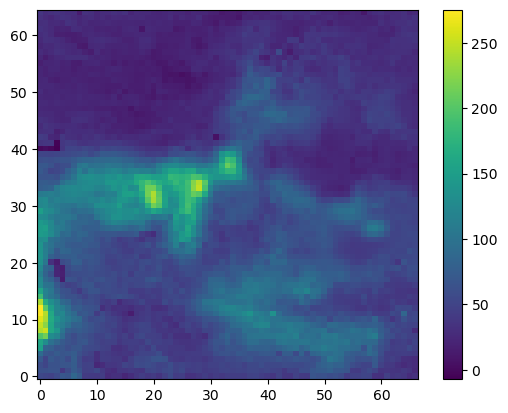

In [15]:
plt.imshow(tensor[51549,1,:,:],origin='lower')

plt.colorbar()

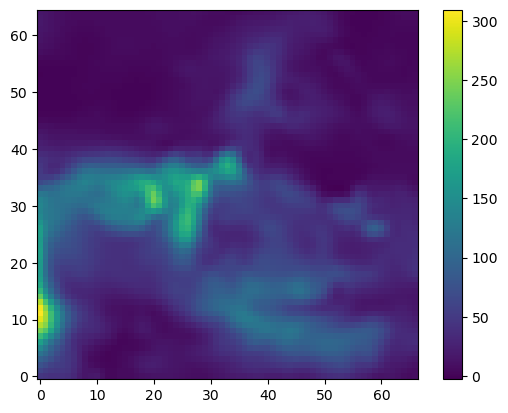

In [16]:
plt.imshow(tensor[51549,0,:,:],origin='lower')

plt.colorbar()

In [ ]:
# plt.imshow(tensor_with_correction[50549,0,:,:],origin='lower')
# plt.colorbar()

# Regression

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, tensor_input, dataframe_target,label_tensor):
        self.tensor_input = tensor_input
        self.dataframe_target = dataframe_target
        self.label_tensor = label_tensor

    def __len__(self):
        return self.tensor_input.shape[0]  # Number of samples

    def __getitem__(self, index,time_to_predict=24,lookback_num=3):
        
        # Check the condition for the current index
        if index >= lookback_num: 
            a = filtered_target_dataframe.loc[index-lookback_num:index-2,'time'].values
            t = np.append(a,filtered_target_dataframe.loc[index-1,'time'].to_numpy())
            if check_timestamps(t[::-1]):
                c = np.arange(index-lookback_num,index+1)
                input_data = self.tensor_input[c,:,:,:]
                input_data = input_data.view(len(c),input_data.shape[2], input_data.shape[3])

        if index < lookback_num or not check_timestamps(t[::-1]):
            input_data = torch.full((1,1),-999) #error indicator


        
        #handling Target data
        
        X_timestamp = self.dataframe_target.loc[index,'time']
        target_timestamp = X_timestamp + pd.DateOffset(hours=time_to_predict)
        matching_row = self.dataframe_target[self.dataframe_target['time'] == target_timestamp]

        if len(matching_row) > 0:

            matching_row = matching_row.index.values[0]
            target_data = self.label_tensor[matching_row]
#             print(f' if_point {target_data.shape}')
            
        else:
#             print(f' X timestamp {X_timestamp}, no corresponding futuretimestamp')
            target_data = torch.full((1,self.label_tensor.shape[1]), float('nan'))[0]
#             print(f'else_point {target_data.shape}')

        return input_data, target_data

class SequentialDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __getitem__(self, index):
        X, y = self.data[index]
        return X, y

    def __len__(self):
        return len(self.data)
    
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
rows_to_keep = (~greecee_stations.isnull().all(axis=1))

# Filter tensor input and target dataframe
filtered_input_tensor = tensor[rows_to_keep][:,:1,:,:]
filtered_target_dataframe = (
                             greecee_stations[rows_to_keep]
                             .pipe(lambda d:d.assign(time = pd.to_datetime(d.time)))
                             .reset_index(drop=True)
                            )
label_tensor = torch.tensor(filtered_target_dataframe.drop('time',axis=1).values, dtype=torch.float32)

original_dataset = CustomDataset(filtered_input_tensor,filtered_target_dataframe.reset_index(drop=True),label_tensor)
filtered_data = [(X, y) for X, y in original_dataset if not torch.all(X.eq(-999))]
new_dataset = SequentialDataset(filtered_data)
train_dataset, test_dataset = train_test_split(new_dataset, test_size=0.2, random_state=42)

# Create data loaders
batch_size = 32  # Set your desired batch size
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print a few batches from the train loader
print("Train Loader:")
for batch_idx, (images, labels) in enumerate(trainloader):
    print(f"Batch {batch_idx}:")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print()

# Print a few batches from the test loader
print("Test Loader:")
for batch_idx, (images, labels) in enumerate(testloader):
    print(f"Batch {batch_idx}:")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print()

In [ ]:
import torch
import torch.nn as nn

from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import os

class IgnoringNullMSELoss(nn.Module):
    def __init__(self):
        super(IgnoringNullMSELoss, self).__init__()

    def forward(self, input_tensor, target_tensor):
        mask = ~torch.isnan(target_tensor)  # Create a mask for non-null values
        masked_input = input_tensor[mask]
        masked_target = target_tensor[mask]

        mse = nn.MSELoss(reduction='mean')(masked_input, masked_target)

        return mse
    
class CrossEntropyLossWithIgnore(nn.Module):
    def __init__(self, ignore_label):
        super(CrossEntropyLossWithIgnore, self).__init__()
        self.ignore_label = ignore_label

    def forward(self, predictions, targets):
        mask = (targets != self.ignore_label).float()  # Create a mask where 1 indicates non-ignored labels
        num_examples = mask.sum()  # Count the number of non-ignored examples
        
        # Apply the mask to the targets and predictions tensors
        masked_targets = targets * mask
        masked_predictions = predictions * mask
        
        # Calculate the cross entropy loss with masked targets and predictions
        loss = F.cross_entropy(masked_predictions, masked_targets, reduction='sum')
        
        # Normalize the loss by the number of non-ignored examples
        loss /= num_examples
        
        return loss
    
class IgnoringTwoCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(IgnoringTwoCrossEntropyLoss, self).__init__()

    def forward(self, inputs, targets):
        
        print(inputs.shape)
        print(targets.shape)
        weights = torch.ones_like(targets)
        weights[targets == 0] = 0


        # Calculate the loss using the filtered predictions and targets
        loss = nn.CrossEntropyLoss()(inputs, targets,weight=weights)
        return loss
    
# Define the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

# Define the Regression ResNet model
class RegressionResNet(nn.Module):
    def __init__(self, input_shape):
        super(RegressionResNet, self).__init__()

        channel, lat_index, lon_index = input_shape

        self.conv1 = nn.Conv2d(channel, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.stage1 = self.make_stage(64, 64, num_blocks=1, stride=1)
        self.stage2 = self.make_stage(64, 128, num_blocks=2, stride=2)
        self.stage3 = self.make_stage(128, 256, num_blocks=2, stride=2)
        self.stage4 = self.make_stage(256, 512, num_blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 142)

    def make_stage(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride=stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
#         print(x.shape, 'level 1')

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
#         print(out.shape,'level 2')
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
#         print(out.shape, 'level 3')
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout1(out)
        out = self.fc2(out)


        return out


# Set the input shape and number of labels
input_shape = (4, 15, 15)


# Create the regression ResNet model
net = RegressionResNet(input_shape).to(device)


In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = IgnoringNullMSELoss()
epochs = 8
net.train()
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        if torch.isnan(inputs).any() :
            print('invalid input detected at iteration ', i)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')
    

# Classification with 10 levels

In [35]:


    
class CustomDataset(Dataset):
    def __init__(self, tensor_input, dataframe_target,label_tensor):
        self.tensor_input = tensor_input
        self.dataframe_target = dataframe_target
        self.label_tensor = label_tensor

    def __len__(self):
        return self.tensor_input.shape[0]  # Number of samples

    def __getitem__(self, index,time_to_predict=24,lookback_num=8):
        
        # Check the condition for the current index
        if index >= lookback_num: 
            
            a = filtered_target_dataframe.loc[index-lookback_num:index-2,'time'].values
            t = np.append(a,filtered_target_dataframe.loc[index-1,'time'].to_numpy())
            
            if check_timestamps(t[::-1]):
                c = np.arange(index-lookback_num,index+1)
                input_data = self.tensor_input[c,:,:,:]
                input_data = input_data.view(len(c),input_data.shape[2], input_data.shape[3])

        if index < lookback_num or not check_timestamps(t[::-1]):
            input_data = torch.full((1,1),-999) #error indicator


        
        #handling Target data
        
        X_timestamp = self.dataframe_target.loc[index,'time']
        target_timestamp = X_timestamp + pd.DateOffset(hours=time_to_predict)
        matching_row = self.dataframe_target[self.dataframe_target['time'] == target_timestamp]

        if len(matching_row) > 0:

            matching_row = matching_row.index.values[0]
            target_data = self.label_tensor[matching_row]
#             print(f' if_point {target_data.shape}')
            
        else:
#             print(f' X timestamp {X_timestamp}, no corresponding futuretimestamp')
            target_data = torch.full((1,self.label_tensor.shape[1]), 0)[0]
#             print(f'else_point {target_data.shape}')
        
        time = filtered_target_dataframe.loc[index,'time']
        return input_data, target_data, time


class SequentialDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __getitem__(self, index):
        X, y = self.data[index]
        return X, y

    def __len__(self):
        return len(self.data)
    
    
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [36]:


without_correction = False # True means basic pm10, False means corrected
tensor = (final_tensor[:,:1,:,:] if without_correction else final_tensor[:,1:,:,:])

df = df_categories.drop('time',axis=1)

rows_to_keep = df.loc[(df != 0).any(axis=1)].index



filtered_input_tensor = tensor[rows_to_keep]

filtered_target_dataframe = (
                             df_categories.loc[rows_to_keep]
                             .pipe(lambda d:d.assign(time = pd.to_datetime(d.time)))
                             .reset_index(drop=True)
                            )

filtered_target_dataframe = filtered_target_dataframe.astype({col: 'int' for col in df.columns if col != 'time'})


label_tensor = torch.tensor(filtered_target_dataframe.drop('time',axis=1).values, dtype=torch.float32)

original_dataset = CustomDataset(filtered_input_tensor,filtered_target_dataframe,label_tensor)


filtered_data_X_y = []
filtered_data_time = []

# Filter and split the data
for X, y, time in original_dataset:
    if (not torch.all(X.eq(-999))) & (not torch.all(y.eq(0))):
        filtered_data_X_y.append((X, y))
        filtered_data_time.append(time)
new_dataset =  SequentialDataset(filtered_data_X_y)

# train_dataset, validation_dataset, test_dataset = split_dataset_by_size(filtered_data_X_y, train_percentage=0.7, validation_percentage=0.1, test_percentage=0.2)
# train_dataset, validation_dataset, test_dataset = SequentialDataset(train_dataset), SequentialDataset(validation_dataset), SequentialDataset(test_dataset)

train_dataset, test_dataset, train_indices, test_indices = train_test_split(new_dataset,filtered_data_time, test_size=0.2, random_state=42)
train_dataset, validation_dataset , train_indices, validation_indices = train_test_split(train_dataset,train_indices, test_size=0.1, random_state=42)





In [37]:

print(f' len of train {len(train_dataset)}, len of validation {len(validation_dataset)}, len of test {len(test_dataset)}')
print(f' total inputs = {len(train_dataset) +len(validation_dataset) + len(test_dataset) }')

# # Create data loaders
batch_size = 32  # Set your desired batch size
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validationloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



 len of train 16636, len of validation 1849, len of test 4622
 total inputs = 23107


In [38]:
def get_metrics_binar(ground_truth,predicted,labels=[1,2],smallest_event_level=None,return_matrix=False):
    
    o = ground_truth.copy()
    p = predicted.copy()

    if type(o)!=np.ndarray:
        o = o.detach().cpu().numpy()
        p =  p.detach().cpu().numpy()
    if smallest_event_level is not None: #added change, label the others as 1, not quite clear why it wasnt the case
#         o[o>=smallest_event_level]=2
#         p[p>=smallest_event_level]=2
            
         o = np.where(o == 0, 0, np.where(o < smallest_event_level, 1, 2))
         p = np.where(p == 0, 0, np.where(p < smallest_event_level, 1, 2))
    
    
    tn, fp, fn, tp = confusion_matrix(o,p,labels=labels).ravel()
    acc = (tp+tn)/(tp+fp+tn+fn)
    if tp+fp==0:
        prc = np.nan
    else:
        prc = tp/(tp+fp)
    if tp+fn==0:
        rcl = np.nan
    else:
        rcl = tp/(tp+fn)
    if rcl==np.nan or prc==np.nan or rcl==0:
        prcrcl_ratio = np.nan
        prcrcl_avg = np.nan
    else:
        prcrcl_ratio = prc/rcl
        prcrcl_avg = (prc+rcl)/2
    if tp+fp+fn==0:
        csi = np.nan
    else:
        csi = tp/(tp+fp+fn)
    
    if return_matrix:
        return confusion_matrix(o,p,labels=labels)

    return [acc, prc, rcl, prcrcl_ratio, prcrcl_avg, csi]       

In [39]:

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class ClassificationResNet(nn.Module):
    def __init__(self, input_shape, num_classes, num_stations):
        super(ClassificationResNet, self).__init__()

        channel, lat_index, lon_index = input_shape

        self.conv1 = nn.Conv2d(channel, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.stage1 = self.make_stage(64, 64, num_blocks=1, stride=1)
        self.stage2 = self.make_stage(64, 128, num_blocks=2, stride=2)
        self.stage3 = self.make_stage(128, 256, num_blocks=2, stride=2)
        self.stage4 = self.make_stage(256, 512, num_blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 480)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(480, 460)
        self.fc3 = nn.Linear(460, num_stations * num_classes)
        self.num_stations = num_stations
        self.num_classes = num_classes

    def make_stage(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride=stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = out.view(-1, self.num_classes, self.num_stations)
        out = out.permute(0, 2, 1)
        return out

past_times, lat_size, lon_size = 8, 65, 67
# Set the input shape and number of labels
input_shape = (past_times+1, lat_size, lon_size) #channels 1+lookback number
w = torch.ones(num_stations)

# Create the regression ResNet model

# summary(net,input_shape)

In [40]:
num_stations = 138
net = ClassificationResNet(input_shape,num_stations,11).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=2e-3) 

class_weights = torch.tensor([0,1,1,1,1,1,1,1,1,1,1.]).to(device)

criterion = nn.CrossEntropyLoss(reduction = 'none',weight=class_weights)

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

smallest_event_level = 9
#stations_weights
w = torch.ones(num_stations).to(device)


train_running_loss = []
validation_running_loss = []
train_f1_scores = []
valid_f1_scores = []

labels_to_use = [1,2,3,4,5,6,7,8,9,10]

num_epochs = 100
for epoch in range(num_epochs):
    net.train() 
    running_loss = 0.0
    y_true_train = []
    y_pred_train = []

    for i, data in tqdm(enumerate(trainloader, 0)):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

#         ordinal_labels = convert_to_ordinal_labels(labels, num_classes=12).to(device)

        outputs = net(inputs)
        labels = labels.type(torch.LongTensor).to(device)
        loss = ((criterion(outputs, labels) * (labels>0) * w).mean(0)).mean()
        loss.backward()

        optimizer.step()
        running_loss += loss.item()
        
        predicted = torch.argmax(outputs, dim=1)
        y_true_train.extend(labels.cpu().numpy())
        y_pred_train.extend(predicted.cpu().numpy())
        
        
    train_loss = running_loss / len(trainloader)
    train_running_loss.append(train_loss)
            

    # Reshape the tensors to merge batch and class dimensions
    predictions_train = np.concatenate(y_pred_train).reshape(-1, num_stations).flatten()
    ground_truth_train = np.concatenate(y_true_train).reshape(-1, num_stations).flatten()
    
    acc, prc, rcl, prcrcl_ratio, prcrcl_avg, csi = get_metrics_binar(ground_truth_train,predictions_train,labels=[1,2],smallest_event_level=smallest_event_level)

    train_f1_scores.append(csi)

    # Validation loop
    net.eval()  # Set the model to evaluation mode
    y_true_valid = []
    y_pred_valid = []

    with torch.no_grad():
        for i, data in enumerate(validationloader, 0):
            inputs, labels =data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            outputs = torch.argmax(outputs, dim=1)
            y_true_valid.extend(labels.cpu().numpy())
            y_pred_valid.extend(outputs.cpu().numpy())
    
    # Concatenate predictions and labels along batch dimension
    predictions_valid = np.concatenate(y_pred_valid).reshape(-1, num_stations).flatten()
    ground_truth_valid = np.concatenate(y_true_valid).reshape(-1, num_stations).flatten()

    acc_test, prc_test, rcl_test, prcrcl_ratio_test, prcrcl_avg_test, csi_test = get_metrics_binar(ground_truth_valid,predictions_valid,labels=[1,2],smallest_event_level=smallest_event_level)

    valid_loss = running_loss / len(validationloader)
    validation_running_loss.append(valid_loss)
    # Calculate the average validation loss for this epoch
    valid_f1_scores.append(csi_test)
    scheduler.step(prc_test)

    num_classes = len(labels_to_use)


#     class_labels = [f'Class {i+1}' for i in range(num_classes)]


    f_string_template = f'''Epoch [{epoch+1}/{num_epochs}] - 
              Train Loss: {train_loss:.4f},   Valid Loss: {valid_loss:.4f} \n'''
    
    train_string = f' Train acc {acc:.3f}, Train percision {prc:.3f}, train recall {rcl:.3f}'
    test_string = f' Validation acc {acc_test:.3f}, Validation percision {prc_test:.3f}, Validation recall {rcl_test:.3f}'
    
    print(f_string_template + '\n' + train_string  + '\n' + test_string)
  
    

#     for i in range(num_classes):
#         f_string_template += f'''
#               Train F1: {class_labels[i]} - {fscore_classes[i]:.4f}, Validation F1: {class_labels[i]}: {fscore_valid_classes[i]:.4f}
#               Train Precision: {class_labels[i]}: {precision1[i]:.4f}, Valid Precision: {class_labels[i]}: {precision2[i]:.4f}
#               Train Recall: {class_labels[i]}: {recall1[i]:.4f}, Valid Recall: {class_labels[i]}: {recall2[i]:.4f}
#         '''

    

print('Training Done')
# torch.save(net.state_dict(),"/home/labs/rudich/sagima/station_vs_satellite/model_10_levels.pth")

520it [02:29,  3.47it/s]


Epoch [1/15] - 
              Train Loss: 0.4057,   Valid Loss: 3.6372 

 Train acc 0.778, Train percision 0.462, train recall 0.656
 Validation acc 0.835, Validation percision 0.584, Validation recall 0.497


520it [02:16,  3.81it/s]


Epoch [2/15] - 
              Train Loss: 0.3899,   Valid Loss: 3.4955 

 Train acc 0.792, Train percision 0.487, train recall 0.704
 Validation acc 0.772, Validation percision 0.444, Validation recall 0.755


520it [02:15,  3.85it/s]


Epoch [3/15] - 
              Train Loss: 0.3833,   Valid Loss: 3.4366 

 Train acc 0.802, Train percision 0.504, train recall 0.718
 Validation acc 0.802, Validation percision 0.489, Validation recall 0.732


520it [02:18,  3.75it/s]


Epoch [4/15] - 
              Train Loss: 0.3767,   Valid Loss: 3.3776 

 Train acc 0.812, Train percision 0.522, train recall 0.720
 Validation acc 0.802, Validation percision 0.489, Validation recall 0.755


520it [02:26,  3.55it/s]


Epoch [5/15] - 
              Train Loss: 0.3694,   Valid Loss: 3.3115 

 Train acc 0.824, Train percision 0.545, train recall 0.727
 Validation acc 0.841, Validation percision 0.572, Validation recall 0.693


520it [02:27,  3.52it/s]


Epoch [6/15] - 
              Train Loss: 0.3612,   Valid Loss: 3.2386 

 Train acc 0.834, Train percision 0.567, train recall 0.726
 Validation acc 0.829, Validation percision 0.538, Validation recall 0.753


520it [02:28,  3.50it/s]


Epoch 00007: reducing learning rate of group 0 to 1.0000e-03.
Epoch [7/15] - 
              Train Loss: 0.3529,   Valid Loss: 3.1642 

 Train acc 0.841, Train percision 0.582, train recall 0.738
 Validation acc 0.841, Validation percision 0.566, Validation recall 0.747


520it [02:19,  3.72it/s]


Epoch [8/15] - 
              Train Loss: 0.3399,   Valid Loss: 3.0471 

 Train acc 0.855, Train percision 0.613, train recall 0.752
 Validation acc 0.854, Validation percision 0.595, Validation recall 0.746


520it [02:20,  3.71it/s]


Epoch [9/15] - 
              Train Loss: 0.3333,   Valid Loss: 2.9880 

 Train acc 0.860, Train percision 0.623, train recall 0.760
 Validation acc 0.856, Validation percision 0.599, Validation recall 0.749


520it [02:25,  3.58it/s]


Epoch [10/15] - 
              Train Loss: 0.3286,   Valid Loss: 2.9465 

 Train acc 0.864, Train percision 0.632, train recall 0.764
 Validation acc 0.860, Validation percision 0.612, Validation recall 0.741


520it [02:16,  3.80it/s]


Epoch [11/15] - 
              Train Loss: 0.3239,   Valid Loss: 2.9041 

 Train acc 0.868, Train percision 0.642, train recall 0.768
 Validation acc 0.866, Validation percision 0.633, Validation recall 0.721


520it [02:33,  3.39it/s]


Epoch [12/15] - 
              Train Loss: 0.3201,   Valid Loss: 2.8698 

 Train acc 0.871, Train percision 0.651, train recall 0.771
 Validation acc 0.869, Validation percision 0.639, Validation recall 0.731


520it [02:30,  3.46it/s]


Epoch [13/15] - 
              Train Loss: 0.3163,   Valid Loss: 2.8360 

 Train acc 0.874, Train percision 0.657, train recall 0.775
 Validation acc 0.868, Validation percision 0.630, Validation recall 0.752


520it [02:28,  3.50it/s]


Epoch [14/15] - 
              Train Loss: 0.3132,   Valid Loss: 2.8080 

 Train acc 0.876, Train percision 0.663, train recall 0.778
 Validation acc 0.871, Validation percision 0.642, Validation recall 0.744


520it [02:28,  3.51it/s]


Epoch [15/15] - 
              Train Loss: 0.3099,   Valid Loss: 2.7782 

 Train acc 0.879, Train percision 0.669, train recall 0.780
 Validation acc 0.871, Validation percision 0.638, Validation recall 0.753
Training Done


In [178]:
# ordinal_labels.shape

torch.Size([32, 138, 11])

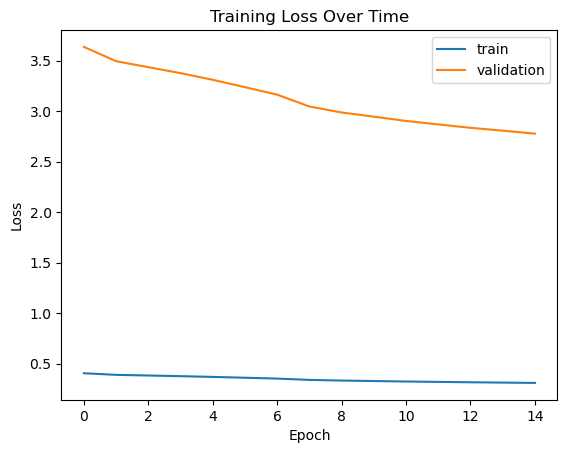

In [41]:
plt.plot(train_running_loss,label='train')
plt.plot(validation_running_loss,label='validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

In [432]:

from sklearn.metrics import confusion_matrix
    
net.eval()
all_predictions = []
all_labels = []
all_input = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        outputs = torch.argmax(outputs, dim=1)
        all_predictions.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Reshape the tensors to merge batch and class dimensions
predictions_test = np.concatenate(all_predictions).reshape(-1, num_stations).flatten()
ground_truth_test = np.concatenate(all_labels).reshape(-1, num_stations).flatten()


In [207]:
outputs.shape

torch.Size([22, 138])

In [433]:
    

precision, recall, _, _ = precision_recall_fscore_support(ground_truth_test,
                                                          predictions_test,
                                                          labels=labels_to_use, average='macro')


precision_micro, recall_micro, _, _ = precision_recall_fscore_support(ground_truth_test,
                                                                      predictions_test,
                                                                      labels=labels_to_use,  average='micro')


precision_weighted, recall_weighted, _, _ = precision_recall_fscore_support(ground_truth_test,
                                                                            predictions_test,
                                                                            labels=labels_to_use,  average='weighted')


precision_per_class, recall_per_class, F1, _ = precision_recall_fscore_support(ground_truth_test,
                                                                               predictions_test,
                                                                               labels=labels_to_use,  average=None)


print("Precision(Macro):", precision) #it treats all classes equally, regardless of the number of samples in each class.
print("Recall(Macro):", recall)

print("Precision (Micro):", precision_micro)
print("Recall (Micro):", recall_micro)

print("Precision (Weighted):", precision_weighted)
print("Recall (Weighted):", recall_weighted)

class_labels = [0] + labels_to_use

# Display the results with class labels
for label, precision, recall in zip(class_labels, precision_per_class, recall_per_class):
    print(f"Class {label+1}: Precision = {precision}, Recall = {recall}")

# print('value count of ground truth')
# unique, counts = np.unique(ground_truth_test, return_counts=True)

# print(np.asarray((unique, counts)).T)

Precision(Macro): 0.06481795079646446
Recall(Macro): 0.187447302991832
Precision (Micro): 0.06042369489393333
Recall (Micro): 0.17404133842057587
Precision (Weighted): 0.06258311620483499
Recall (Weighted): 0.17404133842057587
Class 1: Precision = 0.12633675296637825, Recall = 0.25976394480575343
Class 2: Precision = 0.03906654090729303, Recall = 0.09372262773722628
Class 3: Precision = 0.0421253347037027, Recall = 0.11531057969941512
Class 4: Precision = 0.045502472960486984, Recall = 0.17141687141687142
Class 5: Precision = 0.03812978842153331, Recall = 0.13153058545550014
Class 6: Precision = 0.039229997263023446, Recall = 0.1214574898785425
Class 7: Precision = 0.050036897712341835, Recall = 0.14606210266379446
Class 8: Precision = 0.05754316265505801, Recall = 0.15105958060579164
Class 9: Precision = 0.08029068097983345, Recall = 0.21402496467263307
Class 10: Precision = 0.1299178793949935, Recall = 0.4701242829827916


 Test acc 0.793, Test precision 0.341, Test recall 0.548


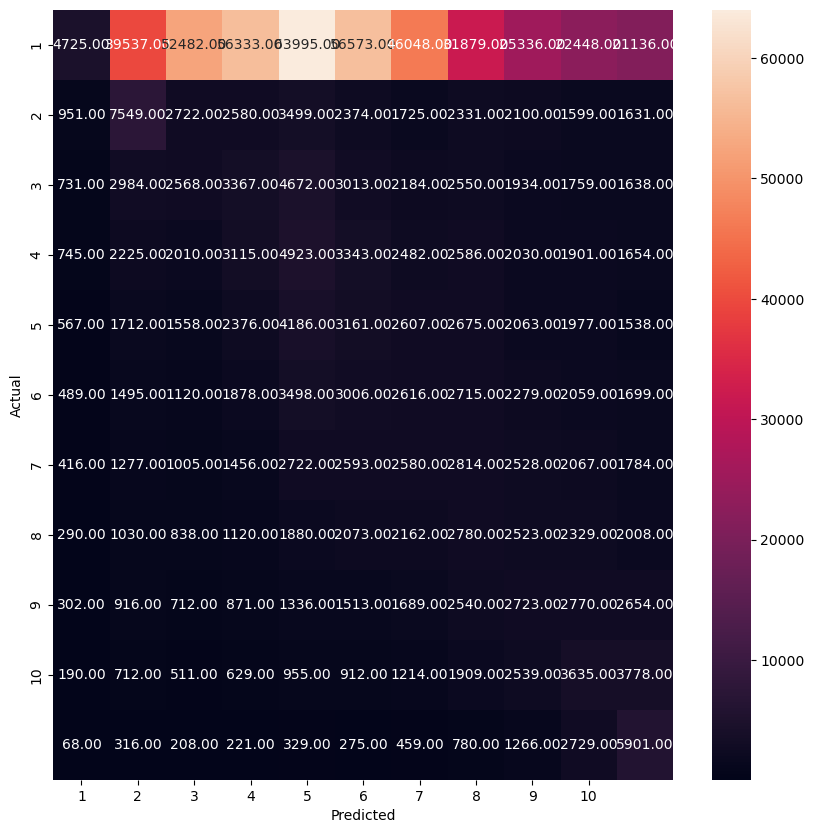

In [444]:
def remove_first_row_from_confusion_matrix(confusion_matrix):
    # Remove the first row  and col(index 0) from the confusion matrix
    reduced_matrix = confusion_matrix[1:,1:]
    return reduced_matrix


acc_test, prc_test, rcl_test, prcrcl_ratio_test, prcrcl_avg_test, csi_test = get_metrics_binar(ground_truth_test,predictions_test,labels=[1,2],smallest_event_level=smallest_event_level)
print(f' Test acc {acc_test:.3f}, Test precision {prc_test:.3f}, Test recall {rcl_test:.3f}')
    

confusion_mat = confusion_matrix(ground_truth_test, predictions_test)
confusion_mat = remove_first_row_from_confusion_matrix(confusion_mat)
cmn = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels_to_use[:cmn.shape[0]], yticklabels=labels_to_use[:cmn.shape[0]])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

<Axes: >

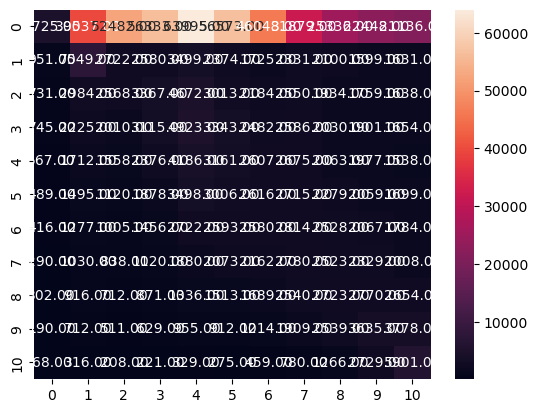

In [443]:
sns.heatmap(confusion_mat,annot=True, fmt='.2f')

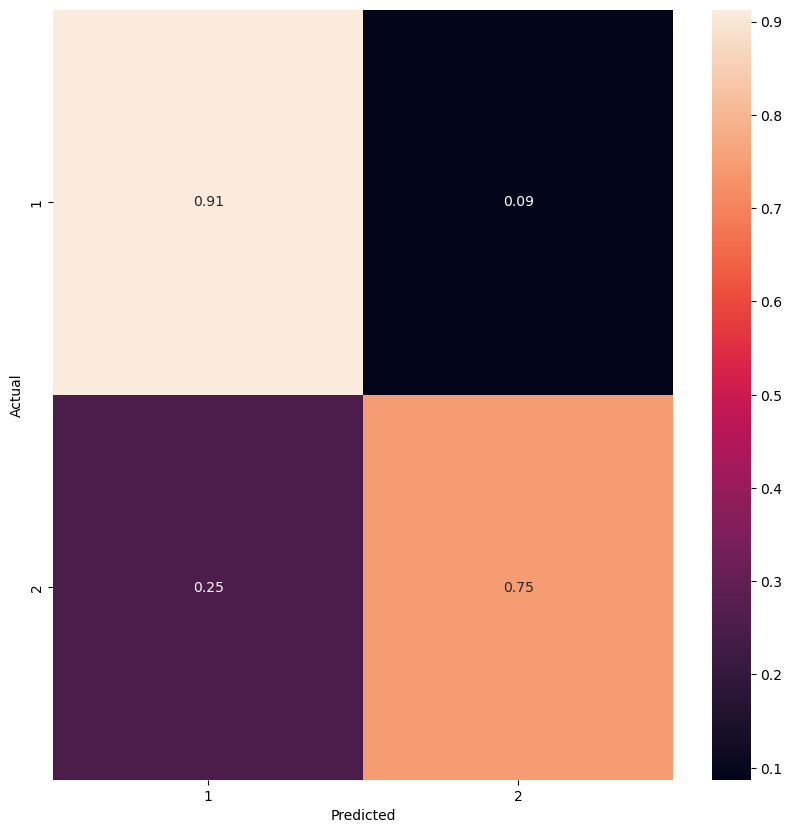

In [332]:
binary_cm = get_metrics_binar(ground_truth_test,predictions_test,labels=[1,2],smallest_event_level=smallest_event_level,return_matrix=True)
cmn = binary_cm.astype('float') / binary_cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=[1,2], yticklabels=[1,2])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## checking per station

In [349]:
from sklearn.metrics import confusion_matrix, classification_report

net.eval()
all_predictions = []
all_labels = []
all_input = []
station_pred_label_dict = {}  # Store evaluation metrics for each station

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        predicted_labels = torch.argmax(outputs, dim=1)
        all_predictions.append(predicted_labels.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

        # Calculate confusion matrix for each batch
        for station_idx in range(num_stations):
            #creating a mask to take relevant predictions and labels
            station_predictions = predicted_labels[:,station_idx]
            station_labels = labels[:, station_idx]
            
            # Calculate station-specific metrics
            if station_idx not in station_pred_label_dict:
                station_pred_label_dict[station_idx] = {'predictions': [], 'labels': []}
            station_pred_label_dict[station_idx]['predictions'].extend(station_predictions.cpu().numpy())
            station_pred_label_dict[station_idx]['labels'].extend(station_labels.cpu().numpy())
            
stations_metrics = {}
# # Print evaluation metrics for each station
for station_idx, metrics in station_pred_label_dict.items():
    station_predictions = np.array(metrics['predictions'])
    station_labels = np.array(metrics['labels'])
#     print(f"Station {station_idx}:")
    acc, prc, rcl, prcrcl_ratio, prcrcl_avg, csi = get_metrics_binar(station_labels,
                                                                     station_predictions,labels=[1,2],
                                                                     smallest_event_level=smallest_event_level)
    stations_metrics[station_idx] = {'acc':acc, 'prc':prc, 'rcl':rcl,'prcrcl_ratio':prcrcl_ratio, 'prcrcl_avg':prcrcl_avg, 'csi':csi}
    
#         sum += prc
#     stations_avg_prc[station_idx] = sum/len(station_labels)



In [345]:
# with open('not_corrected_dict.pkl', 'wb') as f:
#     pickle.dump(stations_metrics, f)
with open('not_corrected_dict.pkl', 'rb') as f:
    not_corrected_dict = pickle.load(f)

In [358]:
# with open('corrected_dict.pkl', 'wb') as f:
#     pickle.dump(stations_metrics, f)
with open('corrected_dict.pkl', 'rb') as f:
    corrected_dict = pickle.load(f)

In [402]:
def calculate_dict_differences(dict1, dict2):
    diff_dict = {}

    for key in dict1:
        if key in dict2:
            diff_dict[key] = {}
            for inner_key in dict1[key]:
                if inner_key in dict2[key]:
                    diff_dict[key][inner_key] = dict1[key][inner_key] - dict2[key][inner_key]

    return diff_dict
def calculate_metric_stats(dict1):
    metrics = list(dict1[0].keys())  # Assuming all inner dictionaries have the same keys
    result = {}

    for metric in metrics:
        values = [inner_dict[metric] for inner_dict in dict1.values()]
        mean = np.nanmean(values)
        std = np.nanstd(values)
        result[metric] = {'mean': mean, 'std': std}

    return result

def sort_dict_by_inner_key(input_dict, sort_key):
    sorted_items = sorted(input_dict.items(), key=lambda x: x[1][sort_key], reverse=True)
    return sorted_items


def get_top_k_keys(sorted_items, k,sort_key):
    top_k_keys = []
    for key, value in sorted_items:
        if not isinstance(value, dict) or not isinstance(value.get(sort_key), float):
            continue
        if len(top_k_keys) >= k:
            break
        if value[sort_key] != np.nan and value[sort_key] > 0 :
            top_k_keys.append(key)
    return top_k_keys

In [375]:
diff_dict = calculate_dict_differences(corrected_dict,not_corrected_dict) ;diff_dict

{0: {'acc': 0.002557544757033292,
  'prc': 0.10835913312693501,
  'rcl': 0.041666666666666685,
  'prcrcl_ratio': 0.148606811145511,
  'prcrcl_avg': 0.07501289989680088,
  'csi': 0.052678571428571436},
 1: {'acc': -0.012329656067488592,
  'prc': -0.027282065814175915,
  'rcl': 0.008988764044943753,
  'prcrcl_ratio': -0.04255959760546901,
  'prcrcl_avg': -0.009146650884616081,
  'csi': -0.015790989376679887},
 2: {'acc': -0.008787346221441061,
  'prc': -0.039433490697028506,
  'rcl': 0.021052631578947323,
  'prcrcl_ratio': -0.07570360890090899,
  'prcrcl_avg': -0.009190429559040592,
  'csi': -0.01300437936683052},
 3: {'acc': -0.009359251259899226,
  'prc': -0.026108976597974176,
  'rcl': 0.038922155688622784,
  'prcrcl_ratio': -0.07109020258470145,
  'prcrcl_avg': 0.006406589545324248,
  'csi': -0.001790633608815484},
 4: {'acc': -0.004548408057180042,
  'prc': -0.005404202856904461,
  'rcl': -0.011111111111111072,
  'prcrcl_ratio': 0.006257010168800203,
  'prcrcl_avg': -0.0082576569840

In [373]:
calculate_metric_stats(diff_dict)

{'acc': {'mean': 0.00017161619159516408, 'std': 0.01917066023697661},
 'prc': {'mean': 0.004025980311118418, 'std': 0.10991564634711191},
 'rcl': {'mean': -0.008475519130204785, 'std': 0.11844144855081071},
 'prcrcl_ratio': {'mean': 0.05321021262711517, 'std': 0.3206922523227906},
 'prcrcl_avg': {'mean': 0.004790663052654472, 'std': 0.06841974338899759},
 'csi': {'mean': -0.0021699684562278693, 'std': 0.0859009330024367}}

In [387]:
sorted_items = sort_dict_by_inner_key(diff_dict, sort_key='prc')
for key, value in sorted_items:
    print(f"Key: {key}, {sort_key}: {value[sort_key]}")

Key: 18, prc: nan
Key: 22, prc: nan
Key: 25, prc: nan
Key: 27, prc: 0.4
Key: 49, prc: 0.3333333333333333
Key: 33, prc: 0.18000000000000005
Key: 29, prc: 0.16666666666666663
Key: 41, prc: 0.11818181818181817
Key: 0, prc: 0.10835913312693501
Key: 46, prc: 0.10077519379844968
Key: 35, prc: 0.10000000000000003
Key: 20, prc: 0.08639587362991624
Key: 17, prc: 0.07090909090909092
Key: 32, prc: 0.05972515856236782
Key: 21, prc: 0.04358974358974366
Key: 14, prc: 0.0267857142857143
Key: 6, prc: 0.018704579817587663
Key: 24, prc: 0.018115942028985588
Key: 12, prc: 0.01790995643385085
Key: 23, prc: 0.008928571428571397
Key: 11, prc: 0.00811965811965809
Key: 19, prc: 0.0
Key: 26, prc: 0.0
Key: 8, prc: -0.0036438279627357684
Key: 4, prc: -0.005404202856904461
Key: 5, prc: -0.009175272333167062
Key: 13, prc: -0.010863635285466855
Key: 16, prc: -0.02398401065956024
Key: 3, prc: -0.026108976597974176
Key: 1, prc: -0.027282065814175915
Key: 7, prc: -0.02815210302731108
Key: 28, prc: -0.03809523809523812

In [406]:
top_k_keys = get_top_k_keys(sorted_items, 25,sort_key='prc')
print(top_k_keys)

[27, 49, 33, 29, 41, 0, 46, 35, 20, 17, 32, 21, 14, 6, 24, 12, 23, 11, 62, 59, 44, 54, 39, 38, 55]


## Looking for specific time frames(seasons/etc)

In [200]:
from sklearn.metrics import confusion_matrix, classification_report

net.eval()
all_predictions = []
all_labels = []
all_input = []
station_pred_label_dict = {}  # Store evaluation metrics for each station

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs) #batch, classes, stations
        predicted_labels = torch.argmax(outputs, dim=1)
        all_predictions.append(predicted_labels.cpu().numpy())
        all_labels.append(labels.cpu().numpy())


In [201]:

predictions_test_time_station = np.concatenate(all_predictions).reshape(-1, num_stations)
ground_truth_test_time_station = np.concatenate(all_labels).reshape(-1, num_stations)


In [207]:

results_df = pd.DataFrame(index=test_indices, columns=['accuracy','precision', 'recall', 'prcrcl_ratio','prcrcl_avg', 'csi'])

# Loop over timestamps and compute metrics
for idx, timestamp in enumerate(test_indices):
   
    metrics = get_metrics_binar(ground_truth_test_time_station[idx],predictions_test_time_station[idx],labels=[1,2],smallest_event_level=smallest_event_level)
    results_df.loc[timestamp] = metrics
results_df['index_in_timestamp_list'] = range(0, len(test_indices))
results_df = results_df.sort_index()

In [209]:



def get_season(month):
    if 3 <= month <= 5:
        return 'spring'
    elif 6 <= month <= 8:
        return 'summer'
    elif 9 <= month <= 11:
        return 'fall'
    else:
        return 'winter'


results_df.index = pd.to_datetime(results_df.index)
results_df['year'] = results_df.index.year
results_df['month'] = results_df.index.month
results_df['season'] = results_df['month'].apply(get_season)


avg_precision_by_month = results_df.groupby(['year', 'month'])['precision'].mean()
avg_precision_by_year = results_df.groupby('year')['precision'].mean()
avg_precision_by_season = results_df.groupby('season')['precision'].mean()


print("Average Precision by Month:\n", avg_precision_by_month)
print("\nAverage Precision by Year:\n", avg_precision_by_year)
print("\nAverage Precision by Season:\n", avg_precision_by_season)

Average Precision by Month:
 year  month
2013  1        0.686558
      2        0.625185
      3        0.526114
      4        0.612918
      5        0.541032
                 ...   
2020  8        0.808642
      9           0.376
      10       0.511235
      11       0.622701
      12       0.569735
Name: precision, Length: 96, dtype: object

Average Precision by Year:
 year
2013    0.600234
2014    0.639003
2015    0.642352
2016     0.55349
2017    0.566264
2018    0.506327
2019     0.42542
2020    0.556314
Name: precision, dtype: object

Average Precision by Season:
 season
fall       0.55733
spring    0.508036
summer    0.487478
winter    0.670617
Name: precision, dtype: object


### Only training on the top 25 stations where the correction is better

In [422]:


without_correction = False  # True means basic pm10, False means corrected
tensor = (final_tensor[:,:1,:,:] if without_correction else final_tensor[:,1:,:,:])
mapped_list = [result_dict[key] for key in top_k_keys]

df = df_categories[mapped_list]

rows_to_keep = df.loc[(df != 0).any(axis=1)].index



filtered_input_tensor = tensor[rows_to_keep]

filtered_target_dataframe = (
                             df_categories[mapped_list+['time']]
                             .loc[rows_to_keep]
                             .pipe(lambda d:d.assign(time = pd.to_datetime(d.time)))
                             .reset_index(drop=True)
                            )

filtered_target_dataframe = filtered_target_dataframe.astype({col: 'int' for col in df.columns if col != 'time'})


label_tensor = torch.tensor(filtered_target_dataframe.drop('time',axis=1).values, dtype=torch.float32)

original_dataset = CustomDataset(filtered_input_tensor,filtered_target_dataframe,label_tensor)


filtered_data_X_y = []
filtered_data_time = []

# Filter and split the data
for X, y, time in original_dataset:
    if (not torch.all(X.eq(-999))) & (not torch.all(y.eq(0))):
        filtered_data_X_y.append((X, y))
        filtered_data_time.append(time)
new_dataset =  SequentialDataset(filtered_data_X_y)

# train_dataset, validation_dataset, test_dataset = split_dataset_by_size(filtered_data_X_y, train_percentage=0.7, validation_percentage=0.1, test_percentage=0.2)
# train_dataset, validation_dataset, test_dataset = SequentialDataset(train_dataset), SequentialDataset(validation_dataset), SequentialDataset(test_dataset)
train_dataset, test_dataset = train_test_split(new_dataset, test_size=0.2, random_state=42)
train_dataset, validation_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)

print(f' len of train {len(train_dataset)}, len of validation {len(validation_dataset)}, len of test {len(test_dataset)}')
print(f' total inputs = {len(train_dataset) +len(validation_dataset) + len(test_dataset) }')

# # Create data loaders
batch_size = 32  # Set your desired batch size
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validationloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



 len of train 7902, len of validation 878, len of test 2195
 total inputs = 10975


In [423]:
num_stations = df.shape[1]

net = ClassificationResNet(input_shape,num_stations,11).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=2e-3) 

class_weights = torch.tensor([0,1,1,1,1,1,1,1,1,1,1.]).to(device)

criterion = nn.CrossEntropyLoss(reduction = 'none',weight=class_weights)

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

smallest_event_level = 9
#stations_weights
w = torch.ones(num_stations).to(device)


train_running_loss = []
validation_running_loss = []
train_f1_scores = []
valid_f1_scores = []

labels_to_use = [1,2,3,4,5,6,7,8,9,10]

num_epochs = 50
for epoch in range(num_epochs):
    net.train() 
    running_loss = 0.0
    y_true_train = []
    y_pred_train = []

    for i, data in tqdm(enumerate(trainloader, 0)):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

#         ordinal_labels = convert_to_ordinal_labels(labels, num_classes=12).to(device)

        outputs = net(inputs)
        labels = labels.type(torch.LongTensor).to(device)
        loss = ((criterion(outputs, labels) * (labels>0) * w).mean(0)).mean()
        loss.backward()

        optimizer.step()
        running_loss += loss.item()
        
        predicted = torch.argmax(outputs, dim=1)
        y_true_train.extend(labels.cpu().numpy())
        y_pred_train.extend(predicted.cpu().numpy())
        
        
    train_loss = running_loss / len(trainloader)
    train_running_loss.append(train_loss)
            

    # Reshape the tensors to merge batch and class dimensions
    predictions_train = np.concatenate(y_pred_train).reshape(-1, num_stations).flatten()
    ground_truth_train = np.concatenate(y_true_train).reshape(-1, num_stations).flatten()
    
    acc, prc, rcl, prcrcl_ratio, prcrcl_avg, csi = get_metrics_binar(ground_truth_train,predictions_train,labels=[1,2],smallest_event_level=smallest_event_level)

    train_f1_scores.append(csi)

    # Validation loop
    net.eval()  # Set the model to evaluation mode
    y_true_valid = []
    y_pred_valid = []

    with torch.no_grad():
        for i, data in enumerate(validationloader, 0):
            inputs, labels =data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            outputs = torch.argmax(outputs, dim=1)
            y_true_valid.extend(labels.cpu().numpy())
            y_pred_valid.extend(outputs.cpu().numpy())
    
    # Concatenate predictions and labels along batch dimension
    predictions_valid = np.concatenate(y_pred_valid).reshape(-1, num_stations).flatten()
    ground_truth_valid = np.concatenate(y_true_valid).reshape(-1, num_stations).flatten()

    acc_test, prc_test, rcl_test, prcrcl_ratio_test, prcrcl_avg_test, csi_test = get_metrics_binar(ground_truth_valid,predictions_valid,labels=[1,2],smallest_event_level=smallest_event_level)

    valid_loss = running_loss / len(validationloader)
    validation_running_loss.append(valid_loss)
    # Calculate the average validation loss for this epoch
    valid_f1_scores.append(csi_test)
    scheduler.step(prc_test)

    num_classes = len(labels_to_use)


#     class_labels = [f'Class {i+1}' for i in range(num_classes)]


    f_string_template = f'''Epoch [{epoch+1}/{num_epochs}] - 
              Train Loss: {train_loss:.4f},   Valid Loss: {valid_loss:.4f} \n'''
    
    train_string = f' Train acc {acc:.3f}, Train percision {prc:.3f}, train recall {rcl:.3f}'
    test_string = f' Validation acc {acc_test:.3f}, Validation percision {prc_test:.3f}, Validation recall {rcl_test:.3f}'
    
    print(f_string_template + '\n' + train_string  + '\n' + test_string)
  
    

#     for i in range(num_classes):
#         f_string_template += f'''
#               Train F1: {class_labels[i]} - {fscore_classes[i]:.4f}, Validation F1: {class_labels[i]}: {fscore_valid_classes[i]:.4f}
#               Train Precision: {class_labels[i]}: {precision1[i]:.4f}, Valid Precision: {class_labels[i]}: {precision2[i]:.4f}
#               Train Recall: {class_labels[i]}: {recall1[i]:.4f}, Valid Recall: {class_labels[i]}: {recall2[i]:.4f}
#         '''

    

print('Training Done')
# torch.save(net.state_dict(),"/home/labs/rudich/sagima/station_vs_satellite/model_10_levels.pth")

247it [00:07, 34.68it/s]


Epoch [1/50] - 
              Train Loss: 0.5079,   Valid Loss: 4.4802 

 Train acc 0.824, Train percision 0.366, train recall 0.474
 Validation acc 0.881, Validation percision 0.589, Validation recall 0.312


247it [00:06, 38.27it/s]


Epoch [2/50] - 
              Train Loss: 0.4767,   Valid Loss: 4.2053 

 Train acc 0.862, Train percision 0.477, train recall 0.597
 Validation acc 0.870, Validation percision 0.505, Validation recall 0.619


247it [00:06, 38.47it/s]


Epoch [3/50] - 
              Train Loss: 0.4640,   Valid Loss: 4.0936 

 Train acc 0.869, Train percision 0.500, train recall 0.618
 Validation acc 0.884, Validation percision 0.565, Validation recall 0.518


247it [00:06, 39.03it/s]


Epoch [4/50] - 
              Train Loss: 0.4545,   Valid Loss: 4.0097 

 Train acc 0.877, Train percision 0.525, train recall 0.645
 Validation acc 0.889, Validation percision 0.596, Validation recall 0.494


247it [00:06, 38.30it/s]


Epoch [5/50] - 
              Train Loss: 0.4468,   Valid Loss: 3.9416 

 Train acc 0.881, Train percision 0.537, train recall 0.665
 Validation acc 0.883, Validation percision 0.553, Validation recall 0.574


247it [00:07, 35.08it/s]


Epoch [6/50] - 
              Train Loss: 0.4386,   Valid Loss: 3.8694 

 Train acc 0.887, Train percision 0.555, train recall 0.674
 Validation acc 0.878, Validation percision 0.530, Validation recall 0.660


247it [00:04, 49.99it/s]


Epoch [7/50] - 
              Train Loss: 0.4303,   Valid Loss: 3.7959 

 Train acc 0.892, Train percision 0.572, train recall 0.682
 Validation acc 0.864, Validation percision 0.491, Validation recall 0.732


247it [00:06, 38.20it/s]


Epoch [8/50] - 
              Train Loss: 0.4237,   Valid Loss: 3.7377 

 Train acc 0.898, Train percision 0.592, train recall 0.698
 Validation acc 0.896, Validation percision 0.596, Validation recall 0.653


247it [00:06, 35.33it/s]


Epoch [9/50] - 
              Train Loss: 0.4163,   Valid Loss: 3.6723 

 Train acc 0.902, Train percision 0.610, train recall 0.697
 Validation acc 0.900, Validation percision 0.611, Validation recall 0.663


247it [00:04, 50.59it/s]


Epoch [10/50] - 
              Train Loss: 0.4072,   Valid Loss: 3.5923 

 Train acc 0.907, Train percision 0.627, train recall 0.707
 Validation acc 0.903, Validation percision 0.621, Validation recall 0.673


247it [00:06, 40.09it/s]


Epoch [11/50] - 
              Train Loss: 0.4003,   Valid Loss: 3.5315 

 Train acc 0.912, Train percision 0.650, train recall 0.712
 Validation acc 0.892, Validation percision 0.573, Validation recall 0.713


247it [00:06, 37.41it/s]


Epoch [12/50] - 
              Train Loss: 0.3919,   Valid Loss: 3.4573 

 Train acc 0.912, Train percision 0.646, train recall 0.719
 Validation acc 0.909, Validation percision 0.648, Validation recall 0.673


247it [00:07, 34.11it/s]


Epoch [13/50] - 
              Train Loss: 0.3833,   Valid Loss: 3.3808 

 Train acc 0.916, Train percision 0.665, train recall 0.726
 Validation acc 0.907, Validation percision 0.634, Validation recall 0.691


247it [00:06, 38.42it/s]


Epoch [14/50] - 
              Train Loss: 0.3746,   Valid Loss: 3.3041 

 Train acc 0.919, Train percision 0.674, train recall 0.733
 Validation acc 0.909, Validation percision 0.645, Validation recall 0.688


247it [00:06, 35.70it/s]


Epoch [15/50] - 
              Train Loss: 0.3669,   Valid Loss: 3.2370 

 Train acc 0.922, Train percision 0.687, train recall 0.736
 Validation acc 0.894, Validation percision 0.575, Validation recall 0.764


247it [00:06, 37.76it/s]


Epoch [16/50] - 
              Train Loss: 0.3606,   Valid Loss: 3.1810 

 Train acc 0.922, Train percision 0.687, train recall 0.741
 Validation acc 0.914, Validation percision 0.658, Validation recall 0.719


247it [00:06, 35.32it/s]


Epoch [17/50] - 
              Train Loss: 0.3522,   Valid Loss: 3.1070 

 Train acc 0.925, Train percision 0.700, train recall 0.750
 Validation acc 0.904, Validation percision 0.612, Validation recall 0.737


247it [00:04, 50.46it/s]


Epoch [18/50] - 
              Train Loss: 0.3451,   Valid Loss: 3.0443 

 Train acc 0.929, Train percision 0.715, train recall 0.758
 Validation acc 0.910, Validation percision 0.632, Validation recall 0.756


247it [00:04, 50.94it/s]


Epoch [19/50] - 
              Train Loss: 0.3375,   Valid Loss: 2.9776 

 Train acc 0.931, Train percision 0.720, train recall 0.766
 Validation acc 0.910, Validation percision 0.637, Validation recall 0.733


247it [00:04, 50.93it/s]


Epoch [20/50] - 
              Train Loss: 0.3302,   Valid Loss: 2.9127 

 Train acc 0.932, Train percision 0.724, train recall 0.775
 Validation acc 0.915, Validation percision 0.675, Validation recall 0.680


247it [00:05, 44.01it/s]


Epoch [21/50] - 
              Train Loss: 0.3237,   Valid Loss: 2.8553 

 Train acc 0.934, Train percision 0.735, train recall 0.777
 Validation acc 0.919, Validation percision 0.719, Validation recall 0.633


247it [00:06, 38.42it/s]


Epoch [22/50] - 
              Train Loss: 0.3169,   Valid Loss: 2.7952 

 Train acc 0.936, Train percision 0.743, train recall 0.779
 Validation acc 0.910, Validation percision 0.638, Validation recall 0.732


247it [00:06, 35.53it/s]


Epoch [23/50] - 
              Train Loss: 0.3102,   Valid Loss: 2.7365 

 Train acc 0.937, Train percision 0.743, train recall 0.785
 Validation acc 0.919, Validation percision 0.699, Validation recall 0.671


247it [00:06, 38.75it/s]


Epoch [24/50] - 
              Train Loss: 0.3020,   Valid Loss: 2.6639 

 Train acc 0.940, Train percision 0.757, train recall 0.794
 Validation acc 0.893, Validation percision 0.568, Validation recall 0.787


247it [00:06, 37.59it/s]


Epoch [25/50] - 
              Train Loss: 0.2954,   Valid Loss: 2.6056 

 Train acc 0.941, Train percision 0.761, train recall 0.802
 Validation acc 0.914, Validation percision 0.653, Validation recall 0.740


247it [00:06, 38.07it/s]


Epoch [26/50] - 
              Train Loss: 0.2891,   Valid Loss: 2.5503 

 Train acc 0.943, Train percision 0.768, train recall 0.805
 Validation acc 0.913, Validation percision 0.660, Validation recall 0.699


247it [00:06, 40.56it/s]


Epoch 00027: reducing learning rate of group 0 to 1.0000e-03.
Epoch [27/50] - 
              Train Loss: 0.2820,   Valid Loss: 2.4872 

 Train acc 0.945, Train percision 0.777, train recall 0.810
 Validation acc 0.905, Validation percision 0.609, Validation recall 0.771


247it [00:06, 39.80it/s]


Epoch [28/50] - 
              Train Loss: 0.2587,   Valid Loss: 2.2819 

 Train acc 0.949, Train percision 0.791, train recall 0.832
 Validation acc 0.919, Validation percision 0.691, Validation recall 0.698


247it [00:06, 40.86it/s]


Epoch [29/50] - 
              Train Loss: 0.2438,   Valid Loss: 2.1503 

 Train acc 0.955, Train percision 0.819, train recall 0.841
 Validation acc 0.918, Validation percision 0.674, Validation recall 0.733


247it [00:05, 42.50it/s]


Epoch [30/50] - 
              Train Loss: 0.2360,   Valid Loss: 2.0820 

 Train acc 0.955, Train percision 0.815, train recall 0.847
 Validation acc 0.918, Validation percision 0.685, Validation recall 0.694


247it [00:06, 41.14it/s]


Epoch [31/50] - 
              Train Loss: 0.2311,   Valid Loss: 2.0386 

 Train acc 0.957, Train percision 0.825, train recall 0.849
 Validation acc 0.922, Validation percision 0.701, Validation recall 0.709


247it [00:05, 41.39it/s]


Epoch [32/50] - 
              Train Loss: 0.2251,   Valid Loss: 1.9855 

 Train acc 0.958, Train percision 0.834, train recall 0.849
 Validation acc 0.919, Validation percision 0.681, Validation recall 0.733


247it [00:06, 41.06it/s]


Epoch 00033: reducing learning rate of group 0 to 5.0000e-04.
Epoch [33/50] - 
              Train Loss: 0.2188,   Valid Loss: 1.9302 

 Train acc 0.960, Train percision 0.844, train recall 0.855
 Validation acc 0.920, Validation percision 0.693, Validation recall 0.709


247it [00:05, 41.21it/s]


Epoch [34/50] - 
              Train Loss: 0.2035,   Valid Loss: 1.7949 

 Train acc 0.964, Train percision 0.855, train recall 0.872
 Validation acc 0.921, Validation percision 0.695, Validation recall 0.716


247it [00:06, 40.76it/s]


Epoch [35/50] - 
              Train Loss: 0.1931,   Valid Loss: 1.7036 

 Train acc 0.965, Train percision 0.858, train recall 0.877
 Validation acc 0.918, Validation percision 0.682, Validation recall 0.712


247it [00:06, 39.94it/s]


Epoch [36/50] - 
              Train Loss: 0.1879,   Valid Loss: 1.6572 

 Train acc 0.967, Train percision 0.865, train recall 0.884
 Validation acc 0.919, Validation percision 0.691, Validation recall 0.701


247it [00:06, 40.91it/s]


Epoch [37/50] - 
              Train Loss: 0.1843,   Valid Loss: 1.6258 

 Train acc 0.967, Train percision 0.867, train recall 0.880
 Validation acc 0.924, Validation percision 0.714, Validation recall 0.702


247it [00:06, 39.88it/s]


Epoch [38/50] - 
              Train Loss: 0.1806,   Valid Loss: 1.5928 

 Train acc 0.968, Train percision 0.872, train recall 0.888
 Validation acc 0.919, Validation percision 0.689, Validation recall 0.702


247it [00:06, 40.21it/s]


Epoch 00039: reducing learning rate of group 0 to 2.5000e-04.
Epoch [39/50] - 
              Train Loss: 0.1776,   Valid Loss: 1.5664 

 Train acc 0.969, Train percision 0.875, train recall 0.887
 Validation acc 0.920, Validation percision 0.699, Validation recall 0.685


247it [00:06, 40.07it/s]


Epoch [40/50] - 
              Train Loss: 0.1693,   Valid Loss: 1.4937 

 Train acc 0.972, Train percision 0.888, train recall 0.898
 Validation acc 0.919, Validation percision 0.688, Validation recall 0.704


247it [00:06, 40.27it/s]


Epoch [41/50] - 
              Train Loss: 0.1639,   Valid Loss: 1.4461 

 Train acc 0.973, Train percision 0.889, train recall 0.905
 Validation acc 0.921, Validation percision 0.700, Validation recall 0.701


247it [00:06, 39.45it/s]


Epoch [42/50] - 
              Train Loss: 0.1617,   Valid Loss: 1.4262 

 Train acc 0.973, Train percision 0.891, train recall 0.904
 Validation acc 0.921, Validation percision 0.697, Validation recall 0.708


247it [00:06, 40.28it/s]


Epoch [43/50] - 
              Train Loss: 0.1586,   Valid Loss: 1.3987 

 Train acc 0.973, Train percision 0.890, train recall 0.904
 Validation acc 0.921, Validation percision 0.696, Validation recall 0.705


247it [00:07, 34.12it/s]


Epoch [44/50] - 
              Train Loss: 0.1557,   Valid Loss: 1.3731 

 Train acc 0.974, Train percision 0.896, train recall 0.908
 Validation acc 0.920, Validation percision 0.692, Validation recall 0.705


247it [00:06, 37.33it/s]


Epoch 00045: reducing learning rate of group 0 to 1.2500e-04.
Epoch [45/50] - 
              Train Loss: 0.1542,   Valid Loss: 1.3598 

 Train acc 0.975, Train percision 0.903, train recall 0.910
 Validation acc 0.920, Validation percision 0.701, Validation recall 0.690


247it [00:07, 34.81it/s]


Epoch [46/50] - 
              Train Loss: 0.1503,   Valid Loss: 1.3258 

 Train acc 0.976, Train percision 0.905, train recall 0.913
 Validation acc 0.920, Validation percision 0.697, Validation recall 0.695


247it [00:06, 39.00it/s]


Epoch [47/50] - 
              Train Loss: 0.1478,   Valid Loss: 1.3042 

 Train acc 0.976, Train percision 0.903, train recall 0.915
 Validation acc 0.920, Validation percision 0.699, Validation recall 0.694


247it [00:06, 35.86it/s]


Epoch [48/50] - 
              Train Loss: 0.1469,   Valid Loss: 1.2956 

 Train acc 0.977, Train percision 0.912, train recall 0.915
 Validation acc 0.922, Validation percision 0.703, Validation recall 0.708


247it [00:06, 40.18it/s]


Epoch [49/50] - 
              Train Loss: 0.1451,   Valid Loss: 1.2800 

 Train acc 0.977, Train percision 0.911, train recall 0.915
 Validation acc 0.919, Validation percision 0.694, Validation recall 0.687


247it [00:06, 40.09it/s]


Epoch [50/50] - 
              Train Loss: 0.1437,   Valid Loss: 1.2679 

 Train acc 0.978, Train percision 0.912, train recall 0.919
 Validation acc 0.920, Validation percision 0.698, Validation recall 0.691
Training Done


In [424]:

from sklearn.metrics import confusion_matrix
    
net.eval()
all_predictions = []
all_labels = []
all_input = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        outputs = torch.argmax(outputs, dim=1)
        all_predictions.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Reshape the tensors to merge batch and class dimensions
predictions_test = np.concatenate(all_predictions).reshape(-1, num_stations).flatten()
ground_truth_test = np.concatenate(all_labels).reshape(-1, num_stations).flatten()


In [421]:
acc_test, prc_test, rcl_test, prcrcl_ratio_test, prcrcl_avg_test, csi_test = get_metrics_binar(ground_truth_test,predictions_test,labels=[1,2],smallest_event_level=smallest_event_level)
print(f' Test acc {acc_test:.3f}, Test precision {prc_test:.3f}, Test recall {rcl_test:.3f}')
    

 Test acc 0.918, Test precision 0.689, Test recall 0.698


In [425]:
acc_test, prc_test, rcl_test, prcrcl_ratio_test, prcrcl_avg_test, csi_test = get_metrics_binar(ground_truth_test,predictions_test,labels=[1,2],smallest_event_level=smallest_event_level)
print(f' Test acc {acc_test:.3f}, Test precision {prc_test:.3f}, Test recall {rcl_test:.3f}')
    

 Test acc 0.920, Test precision 0.695, Test recall 0.712


## Adding the corrected PM10 as a new channel

In [98]:


    
class CustomDataset_for_both_channels_together(Dataset):
    def __init__(self, tensor_input, dataframe_target,label_tensor):
        self.tensor_input = tensor_input
        self.dataframe_target = dataframe_target
        self.label_tensor = label_tensor

    def __len__(self):
        return self.tensor_input.shape[0]  # Number of samples

    def __getitem__(self, index,time_to_predict=24,lookback_num=8):
        
        # Check the condition for the current index
        if index >= lookback_num: 
            
            a = filtered_target_dataframe.loc[index-lookback_num:index-2,'time'].values
            t = np.append(a,filtered_target_dataframe.loc[index-1,'time'].to_numpy())
            
            if check_timestamps(t[::-1]):
                c = np.arange(index-lookback_num,index+1)
                input_data = self.tensor_input[c,:,:,:]
                input_data =   input_data = input_data.view(len(c) * 2,input_data.shape[2], input_data.shape[3])

        if index < lookback_num or not check_timestamps(t[::-1]):
            input_data = torch.full((1,1),-999) #error indicator


        
        #handling Target data
        
        X_timestamp = self.dataframe_target.loc[index,'time']
        target_timestamp = X_timestamp + pd.DateOffset(hours=time_to_predict)
        matching_row = self.dataframe_target[self.dataframe_target['time'] == target_timestamp]

        if len(matching_row) > 0:

            matching_row = matching_row.index.values[0]
            target_data = self.label_tensor[matching_row]
#             print(f' if_point {target_data.shape}')
            
        else:
#             print(f' X timestamp {X_timestamp}, no corresponding futuretimestamp')
            target_data = torch.full((1,self.label_tensor.shape[1]), 0)[0]
#             print(f'else_point {target_data.shape}')
        
        time = filtered_target_dataframe.loc[index,'time']
        return input_data, target_data, time


class SequentialDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __getitem__(self, index):
        X, y = self.data[index]
        return X, y

    def __len__(self):
        return len(self.data)
    
    
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [99]:

df = df_categories.drop('time',axis=1)

rows_to_keep = df.loc[(df != 0).any(axis=1)].index



filtered_input_tensor = final_tensor[rows_to_keep]

filtered_target_dataframe = (
                             df_categories.loc[rows_to_keep]
                             .pipe(lambda d:d.assign(time = pd.to_datetime(d.time)))
                             .reset_index(drop=True)
                            )

filtered_target_dataframe = filtered_target_dataframe.astype({col: 'int' for col in df.columns if col != 'time'})


label_tensor = torch.tensor(filtered_target_dataframe.drop('time',axis=1).values, dtype=torch.float32)


In [100]:



original_dataset = CustomDataset_for_both_channels_together(filtered_input_tensor,filtered_target_dataframe,label_tensor)


filtered_data_X_y = []
filtered_data_time = []

# Filter and split the data
for X, y, time in original_dataset:
    if (not torch.all(X.eq(-999))) & (not torch.all(y.eq(0))):
        filtered_data_X_y.append((X, y))
        filtered_data_time.append(time)
new_dataset =  SequentialDataset(filtered_data_X_y)

# train_dataset, validation_dataset, test_dataset = split_dataset_by_size(filtered_data_X_y, train_percentage=0.7, validation_percentage=0.1, test_percentage=0.2)
# train_dataset, validation_dataset, test_dataset = SequentialDataset(train_dataset), SequentialDataset(validation_dataset), SequentialDataset(test_dataset)
# train_dataset, test_dataset = train_test_split(new_dataset, test_size=0.2, random_state=42)
# train_dataset, validation_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)

train_dataset, test_dataset, train_indices, test_indices = train_test_split(new_dataset,filtered_data_time, test_size=0.2, random_state=42)
train_dataset, validation_dataset , train_indices, validation_indices = train_test_split(train_dataset,train_indices, test_size=0.1, random_state=42)





In [101]:

print(f' len of train {len(train_dataset)}, len of validation {len(validation_dataset)}, len of test {len(test_dataset)}')
print(f' total inputs = {len(train_dataset) +len(validation_dataset) + len(test_dataset) }')

# # Create data loaders
batch_size = 32  # Set your desired batch size
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validationloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



 len of train 16665, len of validation 1852, len of test 4630
 total inputs = 23147


In [102]:
past_times, lat_size, lon_size = 8, 65, 67
# Set the input shape and number of labels
input_shape = ((past_times+1) * 2 , lat_size, lon_size)

In [105]:

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

class ClassificationResNet(nn.Module):
    def __init__(self, input_shape, num_classes, num_stations):
        super(ClassificationResNet, self).__init__()

        channel, lat_index, lon_index = input_shape

        self.conv1 = nn.Conv2d(channel, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.stage1 = self.make_stage(64, 64, num_blocks=1, stride=1)
        self.stage2 = self.make_stage(64, 128, num_blocks=2, stride=2)
        self.stage3 = self.make_stage(128, 256, num_blocks=2, stride=2)
        self.stage4 = self.make_stage(256, 512, num_blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 480)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(480, 460)
        self.fc3 = nn.Linear(460, num_stations * num_classes)
        self.num_stations = num_stations
        self.num_classes = num_classes

    def make_stage(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride=stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = out.view(-1, self.num_classes, self.num_stations)
        out = out.permute(0, 2, 1)
        return out

past_times, lat_size, lon_size = 8, 65, 67
# Set the input shape and number of labels
input_shape = ((past_times+1) * 2, lat_size, lon_size) #channels 1+lookback number
w = torch.ones(num_stations)

# Create the regression ResNet model

# summary(net,input_shape)

In [107]:
num_stations = 138
net = ClassificationResNet(input_shape,num_stations,11).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=2e-3) 

class_weights = torch.tensor([0,1,1,1,1,1,1,1,1,1,1.]).to(device)

criterion = nn.CrossEntropyLoss(reduction = 'none',weight=class_weights)

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

smallest_event_level = 9
#stations_weights
w = torch.ones(num_stations).to(device)


train_running_loss = []
validation_running_loss = []
train_f1_scores = []
valid_f1_scores = []

labels_to_use = [1,2,3,4,5,6,7,8,9,10]

num_epochs = 100
for epoch in range(num_epochs):
    net.train() 
    running_loss = 0.0
    y_true_train = []
    y_pred_train = []

    for i, data in tqdm(enumerate(trainloader, 0)):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

#         ordinal_labels = convert_to_ordinal_labels(labels, num_classes=12).to(device)

        outputs = net(inputs)
        labels = labels.type(torch.LongTensor).to(device)
        loss = ((criterion(outputs, labels) * (labels>0) * w).mean(0)).mean()
        loss.backward()

        optimizer.step()
        running_loss += loss.item()
        
        predicted = torch.argmax(outputs, dim=1)
        y_true_train.extend(labels.cpu().numpy())
        y_pred_train.extend(predicted.cpu().numpy())
        
        
    train_loss = running_loss / len(trainloader)
    train_running_loss.append(train_loss)
            

    # Reshape the tensors to merge batch and class dimensions
    predictions_train = np.concatenate(y_pred_train).reshape(-1, num_stations).flatten()
    ground_truth_train = np.concatenate(y_true_train).reshape(-1, num_stations).flatten()
    
    acc, prc, rcl, prcrcl_ratio, prcrcl_avg, csi = get_metrics_binar(ground_truth_train,predictions_train,labels=[1,2],smallest_event_level=smallest_event_level)

    train_f1_scores.append(csi)

    # Validation loop
    net.eval()  # Set the model to evaluation mode
    y_true_valid = []
    y_pred_valid = []

    with torch.no_grad():
        for i, data in enumerate(validationloader, 0):
            inputs, labels =data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            outputs = torch.argmax(outputs, dim=1)
            y_true_valid.extend(labels.cpu().numpy())
            y_pred_valid.extend(outputs.cpu().numpy())
    
    # Concatenate predictions and labels along batch dimension
    predictions_valid = np.concatenate(y_pred_valid).reshape(-1, num_stations).flatten()
    ground_truth_valid = np.concatenate(y_true_valid).reshape(-1, num_stations).flatten()

    acc_test, prc_test, rcl_test, prcrcl_ratio_test, prcrcl_avg_test, csi_test = get_metrics_binar(ground_truth_valid,predictions_valid,labels=[1,2],smallest_event_level=smallest_event_level)

    valid_loss = running_loss / len(validationloader)
    validation_running_loss.append(valid_loss)
    # Calculate the average validation loss for this epoch
    valid_f1_scores.append(csi_test)
    scheduler.step(prc_test)

    num_classes = len(labels_to_use)


#     class_labels = [f'Class {i+1}' for i in range(num_classes)]


    f_string_template = f'''Epoch [{epoch+1}/{num_epochs}] - 
              Train Loss: {train_loss:.4f},   Valid Loss: {valid_loss:.4f} \n'''
    
    train_string = f' Train acc {acc:.3f}, Train percision {prc:.3f}, train recall {rcl:.3f}'
    test_string = f' Validation acc {acc_test:.3f}, Validation percision {prc_test:.3f}, Validation recall {rcl_test:.3f}'
    
    print(f_string_template + '\n' + train_string  + '\n' + test_string)
  
    

#     for i in range(num_classes):
#         f_string_template += f'''
#               Train F1: {class_labels[i]} - {fscore_classes[i]:.4f}, Validation F1: {class_labels[i]}: {fscore_valid_classes[i]:.4f}
#               Train Precision: {class_labels[i]}: {precision1[i]:.4f}, Valid Precision: {class_labels[i]}: {precision2[i]:.4f}
#               Train Recall: {class_labels[i]}: {recall1[i]:.4f}, Valid Recall: {class_labels[i]}: {recall2[i]:.4f}
#         '''

    

print('Training Done')
# torch.save(net.state_dict(),"/home/labs/rudich/sagima/station_vs_satellite/model_10_levels.pth")

521it [00:14, 36.78it/s]


Epoch [1/100] - 
              Train Loss: 0.4084,   Valid Loss: 3.6688 

 Train acc 0.771, Train percision 0.447, train recall 0.665
 Validation acc 0.771, Validation percision 0.461, Validation recall 0.758


521it [00:14, 35.11it/s]


Epoch [2/100] - 
              Train Loss: 0.3905,   Valid Loss: 3.5079 

 Train acc 0.797, Train percision 0.491, train recall 0.701
 Validation acc 0.809, Validation percision 0.523, Validation recall 0.709


521it [00:14, 35.48it/s]


Epoch [3/100] - 
              Train Loss: 0.3833,   Valid Loss: 3.4435 

 Train acc 0.804, Train percision 0.504, train recall 0.714
 Validation acc 0.817, Validation percision 0.538, Validation recall 0.703


521it [00:14, 35.59it/s]


Epoch [4/100] - 
              Train Loss: 0.3779,   Valid Loss: 3.3949 

 Train acc 0.811, Train percision 0.516, train recall 0.718
 Validation acc 0.811, Validation percision 0.525, Validation recall 0.711


521it [00:14, 34.74it/s]


Epoch [5/100] - 
              Train Loss: 0.3726,   Valid Loss: 3.3468 

 Train acc 0.820, Train percision 0.533, train recall 0.724
 Validation acc 0.821, Validation percision 0.543, Validation recall 0.735


521it [00:14, 36.99it/s]


Epoch [6/100] - 
              Train Loss: 0.3666,   Valid Loss: 3.2928 

 Train acc 0.828, Train percision 0.548, train recall 0.733
 Validation acc 0.816, Validation percision 0.532, Validation recall 0.789


521it [00:14, 36.54it/s]


Epoch [7/100] - 
              Train Loss: 0.3607,   Valid Loss: 3.2398 

 Train acc 0.835, Train percision 0.564, train recall 0.738
 Validation acc 0.829, Validation percision 0.558, Validation recall 0.762


521it [00:14, 35.58it/s]


Epoch [8/100] - 
              Train Loss: 0.3537,   Valid Loss: 3.1771 

 Train acc 0.844, Train percision 0.582, train recall 0.740
 Validation acc 0.813, Validation percision 0.526, Validation recall 0.813


521it [00:13, 37.24it/s]


Epoch [9/100] - 
              Train Loss: 0.3475,   Valid Loss: 3.1215 

 Train acc 0.849, Train percision 0.595, train recall 0.747
 Validation acc 0.820, Validation percision 0.538, Validation recall 0.805


521it [00:15, 33.57it/s]


Epoch [10/100] - 
              Train Loss: 0.3421,   Valid Loss: 3.0727 

 Train acc 0.855, Train percision 0.607, train recall 0.751
 Validation acc 0.849, Validation percision 0.604, Validation recall 0.748


521it [00:14, 36.29it/s]


Epoch [11/100] - 
              Train Loss: 0.3368,   Valid Loss: 3.0256 

 Train acc 0.860, Train percision 0.621, train recall 0.754
 Validation acc 0.856, Validation percision 0.619, Validation recall 0.756


521it [00:14, 36.28it/s]


Epoch [12/100] - 
              Train Loss: 0.3317,   Valid Loss: 2.9792 

 Train acc 0.864, Train percision 0.628, train recall 0.759
 Validation acc 0.838, Validation percision 0.571, Validation recall 0.814


521it [00:13, 37.73it/s]


Epoch [13/100] - 
              Train Loss: 0.3273,   Valid Loss: 2.9399 

 Train acc 0.868, Train percision 0.639, train recall 0.765
 Validation acc 0.849, Validation percision 0.598, Validation recall 0.785


521it [00:14, 35.24it/s]


Epoch [14/100] - 
              Train Loss: 0.3231,   Valid Loss: 2.9026 

 Train acc 0.871, Train percision 0.646, train recall 0.768
 Validation acc 0.863, Validation percision 0.640, Validation recall 0.751


521it [00:14, 36.69it/s]


Epoch [15/100] - 
              Train Loss: 0.3191,   Valid Loss: 2.8667 

 Train acc 0.874, Train percision 0.654, train recall 0.771
 Validation acc 0.861, Validation percision 0.629, Validation recall 0.774


521it [00:15, 33.48it/s]


Epoch [16/100] - 
              Train Loss: 0.3150,   Valid Loss: 2.8296 

 Train acc 0.876, Train percision 0.659, train recall 0.775
 Validation acc 0.872, Validation percision 0.664, Validation recall 0.753


521it [00:15, 34.46it/s]


Epoch [17/100] - 
              Train Loss: 0.3111,   Valid Loss: 2.7942 

 Train acc 0.879, Train percision 0.666, train recall 0.780
 Validation acc 0.868, Validation percision 0.646, Validation recall 0.773


521it [00:14, 37.21it/s]


Epoch [18/100] - 
              Train Loss: 0.3074,   Valid Loss: 2.7615 

 Train acc 0.882, Train percision 0.674, train recall 0.782
 Validation acc 0.875, Validation percision 0.677, Validation recall 0.731


521it [00:14, 37.10it/s]


Epoch [19/100] - 
              Train Loss: 0.3040,   Valid Loss: 2.7306 

 Train acc 0.885, Train percision 0.681, train recall 0.785
 Validation acc 0.866, Validation percision 0.638, Validation recall 0.785


521it [00:15, 34.57it/s]


Epoch [20/100] - 
              Train Loss: 0.3010,   Valid Loss: 2.7035 

 Train acc 0.886, Train percision 0.684, train recall 0.789
 Validation acc 0.877, Validation percision 0.681, Validation recall 0.745


521it [00:14, 34.89it/s]


Epoch [21/100] - 
              Train Loss: 0.2975,   Valid Loss: 2.6725 

 Train acc 0.889, Train percision 0.691, train recall 0.791
 Validation acc 0.873, Validation percision 0.658, Validation recall 0.775


521it [00:13, 37.23it/s]


Epoch [22/100] - 
              Train Loss: 0.2943,   Valid Loss: 2.6436 

 Train acc 0.891, Train percision 0.696, train recall 0.792
 Validation acc 0.873, Validation percision 0.661, Validation recall 0.770


521it [00:15, 33.26it/s]


Epoch [23/100] - 
              Train Loss: 0.2918,   Valid Loss: 2.6213 

 Train acc 0.892, Train percision 0.701, train recall 0.796
 Validation acc 0.874, Validation percision 0.664, Validation recall 0.772


521it [00:14, 34.76it/s]


Epoch [24/100] - 
              Train Loss: 0.2888,   Valid Loss: 2.5941 

 Train acc 0.894, Train percision 0.706, train recall 0.798
 Validation acc 0.872, Validation percision 0.656, Validation recall 0.776


521it [00:13, 37.38it/s]


Epoch [25/100] - 
              Train Loss: 0.2865,   Valid Loss: 2.5735 

 Train acc 0.895, Train percision 0.710, train recall 0.798
 Validation acc 0.874, Validation percision 0.660, Validation recall 0.783


521it [00:14, 36.08it/s]


Epoch 00026: reducing learning rate of group 0 to 1.0000e-03.
Epoch [26/100] - 
              Train Loss: 0.2841,   Valid Loss: 2.5517 

 Train acc 0.897, Train percision 0.715, train recall 0.800
 Validation acc 0.866, Validation percision 0.633, Validation recall 0.807


521it [00:14, 35.76it/s]


Epoch [27/100] - 
              Train Loss: 0.2747,   Valid Loss: 2.4676 

 Train acc 0.902, Train percision 0.728, train recall 0.809
 Validation acc 0.874, Validation percision 0.657, Validation recall 0.795


521it [00:13, 38.08it/s]


Epoch [28/100] - 
              Train Loss: 0.2700,   Valid Loss: 2.4250 

 Train acc 0.905, Train percision 0.734, train recall 0.815
 Validation acc 0.878, Validation percision 0.675, Validation recall 0.774


521it [00:13, 38.06it/s]


Epoch [29/100] - 
              Train Loss: 0.2677,   Valid Loss: 2.4050 

 Train acc 0.906, Train percision 0.739, train recall 0.814
 Validation acc 0.883, Validation percision 0.703, Validation recall 0.736


521it [00:14, 36.75it/s]


Epoch [30/100] - 
              Train Loss: 0.2656,   Valid Loss: 2.3855 

 Train acc 0.908, Train percision 0.743, train recall 0.815
 Validation acc 0.879, Validation percision 0.676, Validation recall 0.775


521it [00:13, 37.65it/s]


Epoch [31/100] - 
              Train Loss: 0.2641,   Valid Loss: 2.3722 

 Train acc 0.908, Train percision 0.743, train recall 0.816
 Validation acc 0.880, Validation percision 0.684, Validation recall 0.765


521it [00:13, 39.32it/s]


Epoch [32/100] - 
              Train Loss: 0.2623,   Valid Loss: 2.3559 

 Train acc 0.910, Train percision 0.749, train recall 0.818
 Validation acc 0.881, Validation percision 0.692, Validation recall 0.748


521it [00:14, 36.74it/s]


Epoch [33/100] - 
              Train Loss: 0.2606,   Valid Loss: 2.3413 

 Train acc 0.910, Train percision 0.749, train recall 0.818
 Validation acc 0.879, Validation percision 0.679, Validation recall 0.770


521it [00:13, 37.35it/s]


Epoch [34/100] - 
              Train Loss: 0.2590,   Valid Loss: 2.3265 

 Train acc 0.911, Train percision 0.753, train recall 0.820
 Validation acc 0.882, Validation percision 0.687, Validation recall 0.768


521it [00:13, 37.91it/s]


Epoch 00035: reducing learning rate of group 0 to 5.0000e-04.
Epoch [35/100] - 
              Train Loss: 0.2575,   Valid Loss: 2.3127 

 Train acc 0.912, Train percision 0.755, train recall 0.822
 Validation acc 0.881, Validation percision 0.685, Validation recall 0.763


521it [00:14, 37.14it/s]


Epoch [36/100] - 
              Train Loss: 0.2518,   Valid Loss: 2.2619 

 Train acc 0.915, Train percision 0.764, train recall 0.826
 Validation acc 0.881, Validation percision 0.682, Validation recall 0.775


521it [00:14, 36.49it/s]


Epoch [37/100] - 
              Train Loss: 0.2492,   Valid Loss: 2.2388 

 Train acc 0.916, Train percision 0.765, train recall 0.828
 Validation acc 0.882, Validation percision 0.693, Validation recall 0.756


521it [00:13, 37.46it/s]


Epoch [38/100] - 
              Train Loss: 0.2480,   Valid Loss: 2.2273 

 Train acc 0.917, Train percision 0.767, train recall 0.830
 Validation acc 0.880, Validation percision 0.682, Validation recall 0.772


521it [00:13, 37.47it/s]


Epoch [39/100] - 
              Train Loss: 0.2468,   Valid Loss: 2.2167 

 Train acc 0.917, Train percision 0.768, train recall 0.830
 Validation acc 0.883, Validation percision 0.694, Validation recall 0.758


521it [00:14, 35.75it/s]


Epoch [40/100] - 
              Train Loss: 0.2457,   Valid Loss: 2.2070 

 Train acc 0.918, Train percision 0.771, train recall 0.831
 Validation acc 0.882, Validation percision 0.690, Validation recall 0.762


521it [00:14, 37.00it/s]


Epoch 00041: reducing learning rate of group 0 to 2.5000e-04.
Epoch [41/100] - 
              Train Loss: 0.2444,   Valid Loss: 2.1957 

 Train acc 0.918, Train percision 0.772, train recall 0.832
 Validation acc 0.882, Validation percision 0.691, Validation recall 0.760


521it [00:14, 36.56it/s]


Epoch [42/100] - 
              Train Loss: 0.2413,   Valid Loss: 2.1679 

 Train acc 0.919, Train percision 0.776, train recall 0.833
 Validation acc 0.884, Validation percision 0.699, Validation recall 0.754


521it [00:16, 31.81it/s]


Epoch [43/100] - 
              Train Loss: 0.2400,   Valid Loss: 2.1559 

 Train acc 0.921, Train percision 0.779, train recall 0.834
 Validation acc 0.883, Validation percision 0.694, Validation recall 0.758


521it [00:15, 32.96it/s]


Epoch [44/100] - 
              Train Loss: 0.2393,   Valid Loss: 2.1491 

 Train acc 0.920, Train percision 0.778, train recall 0.835
 Validation acc 0.882, Validation percision 0.691, Validation recall 0.761


521it [00:15, 32.99it/s]


Epoch [45/100] - 
              Train Loss: 0.2385,   Valid Loss: 2.1426 

 Train acc 0.921, Train percision 0.779, train recall 0.836
 Validation acc 0.883, Validation percision 0.698, Validation recall 0.752


521it [00:15, 33.91it/s]


Epoch [46/100] - 
              Train Loss: 0.2377,   Valid Loss: 2.1354 

 Train acc 0.921, Train percision 0.781, train recall 0.837
 Validation acc 0.883, Validation percision 0.693, Validation recall 0.759


521it [00:14, 35.06it/s]


Epoch 00047: reducing learning rate of group 0 to 1.2500e-04.
Epoch [47/100] - 
              Train Loss: 0.2374,   Valid Loss: 2.1322 

 Train acc 0.922, Train percision 0.782, train recall 0.837
 Validation acc 0.884, Validation percision 0.700, Validation recall 0.749


521it [00:14, 34.93it/s]


Epoch [48/100] - 
              Train Loss: 0.2355,   Valid Loss: 2.1154 

 Train acc 0.922, Train percision 0.783, train recall 0.838
 Validation acc 0.883, Validation percision 0.696, Validation recall 0.756


521it [00:15, 34.60it/s]


Epoch [49/100] - 
              Train Loss: 0.2348,   Valid Loss: 2.1095 

 Train acc 0.923, Train percision 0.785, train recall 0.839
 Validation acc 0.883, Validation percision 0.698, Validation recall 0.751


521it [00:15, 34.19it/s]


Epoch [50/100] - 
              Train Loss: 0.2346,   Valid Loss: 2.1070 

 Train acc 0.922, Train percision 0.784, train recall 0.838
 Validation acc 0.883, Validation percision 0.697, Validation recall 0.755


521it [00:15, 33.40it/s]


Epoch [51/100] - 
              Train Loss: 0.2341,   Valid Loss: 2.1024 

 Train acc 0.923, Train percision 0.786, train recall 0.839
 Validation acc 0.882, Validation percision 0.693, Validation recall 0.753


521it [00:14, 35.17it/s]


Epoch [52/100] - 
              Train Loss: 0.2337,   Valid Loss: 2.0994 

 Train acc 0.923, Train percision 0.787, train recall 0.840
 Validation acc 0.881, Validation percision 0.689, Validation recall 0.758


521it [00:14, 34.83it/s]


Epoch 00053: reducing learning rate of group 0 to 6.2500e-05.
Epoch [53/100] - 
              Train Loss: 0.2333,   Valid Loss: 2.0955 

 Train acc 0.923, Train percision 0.788, train recall 0.839
 Validation acc 0.883, Validation percision 0.698, Validation recall 0.747


521it [00:14, 35.94it/s]


Epoch [54/100] - 
              Train Loss: 0.2323,   Valid Loss: 2.0863 

 Train acc 0.924, Train percision 0.788, train recall 0.841
 Validation acc 0.883, Validation percision 0.697, Validation recall 0.752


521it [00:14, 35.48it/s]


Epoch [55/100] - 
              Train Loss: 0.2322,   Valid Loss: 2.0857 

 Train acc 0.924, Train percision 0.789, train recall 0.840
 Validation acc 0.882, Validation percision 0.694, Validation recall 0.753


521it [00:14, 35.02it/s]


Epoch [56/100] - 
              Train Loss: 0.2317,   Valid Loss: 2.0815 

 Train acc 0.924, Train percision 0.789, train recall 0.841
 Validation acc 0.883, Validation percision 0.696, Validation recall 0.754


521it [00:14, 35.80it/s]


Epoch [57/100] - 
              Train Loss: 0.2318,   Valid Loss: 2.0818 

 Train acc 0.924, Train percision 0.790, train recall 0.841
 Validation acc 0.882, Validation percision 0.695, Validation recall 0.751


521it [00:14, 35.89it/s]


Epoch [58/100] - 
              Train Loss: 0.2315,   Valid Loss: 2.0792 

 Train acc 0.924, Train percision 0.790, train recall 0.840
 Validation acc 0.882, Validation percision 0.694, Validation recall 0.752


521it [00:14, 34.74it/s]


Epoch 00059: reducing learning rate of group 0 to 3.1250e-05.
Epoch [59/100] - 
              Train Loss: 0.2312,   Valid Loss: 2.0771 

 Train acc 0.924, Train percision 0.789, train recall 0.841
 Validation acc 0.882, Validation percision 0.693, Validation recall 0.754


521it [00:14, 35.77it/s]


Epoch [60/100] - 
              Train Loss: 0.2309,   Valid Loss: 2.0737 

 Train acc 0.925, Train percision 0.791, train recall 0.841
 Validation acc 0.882, Validation percision 0.694, Validation recall 0.752


521it [00:14, 36.00it/s]


Epoch [61/100] - 
              Train Loss: 0.2308,   Valid Loss: 2.0729 

 Train acc 0.924, Train percision 0.791, train recall 0.841
 Validation acc 0.882, Validation percision 0.695, Validation recall 0.752


521it [00:14, 35.13it/s]


Epoch [62/100] - 
              Train Loss: 0.2306,   Valid Loss: 2.0714 

 Train acc 0.925, Train percision 0.790, train recall 0.842
 Validation acc 0.883, Validation percision 0.694, Validation recall 0.755


521it [00:14, 35.22it/s]


Epoch [63/100] - 
              Train Loss: 0.2304,   Valid Loss: 2.0699 

 Train acc 0.925, Train percision 0.791, train recall 0.841
 Validation acc 0.883, Validation percision 0.695, Validation recall 0.754


521it [00:14, 36.08it/s]


Epoch [64/100] - 
              Train Loss: 0.2305,   Valid Loss: 2.0709 

 Train acc 0.924, Train percision 0.790, train recall 0.841
 Validation acc 0.883, Validation percision 0.695, Validation recall 0.753


521it [00:14, 35.10it/s]


Epoch 00065: reducing learning rate of group 0 to 1.5625e-05.
Epoch [65/100] - 
              Train Loss: 0.2304,   Valid Loss: 2.0700 

 Train acc 0.925, Train percision 0.791, train recall 0.842
 Validation acc 0.883, Validation percision 0.696, Validation recall 0.751


521it [00:14, 35.75it/s]


Epoch [66/100] - 
              Train Loss: 0.2300,   Valid Loss: 2.0665 

 Train acc 0.925, Train percision 0.791, train recall 0.841
 Validation acc 0.883, Validation percision 0.697, Validation recall 0.751


521it [00:14, 36.10it/s]


Epoch [67/100] - 
              Train Loss: 0.2301,   Valid Loss: 2.0665 

 Train acc 0.925, Train percision 0.791, train recall 0.842
 Validation acc 0.882, Validation percision 0.692, Validation recall 0.755


521it [00:14, 34.89it/s]


Epoch [68/100] - 
              Train Loss: 0.2299,   Valid Loss: 2.0656 

 Train acc 0.925, Train percision 0.791, train recall 0.841
 Validation acc 0.882, Validation percision 0.695, Validation recall 0.750


521it [00:15, 34.21it/s]


Epoch [69/100] - 
              Train Loss: 0.2299,   Valid Loss: 2.0650 

 Train acc 0.925, Train percision 0.791, train recall 0.842
 Validation acc 0.882, Validation percision 0.694, Validation recall 0.753


521it [00:14, 35.42it/s]


Epoch [70/100] - 
              Train Loss: 0.2299,   Valid Loss: 2.0652 

 Train acc 0.924, Train percision 0.790, train recall 0.841
 Validation acc 0.882, Validation percision 0.694, Validation recall 0.751


521it [00:15, 33.18it/s]


Epoch 00071: reducing learning rate of group 0 to 7.8125e-06.
Epoch [71/100] - 
              Train Loss: 0.2298,   Valid Loss: 2.0640 

 Train acc 0.925, Train percision 0.792, train recall 0.842
 Validation acc 0.883, Validation percision 0.696, Validation recall 0.751


521it [00:15, 32.92it/s]


Epoch [72/100] - 
              Train Loss: 0.2296,   Valid Loss: 2.0629 

 Train acc 0.925, Train percision 0.792, train recall 0.842
 Validation acc 0.883, Validation percision 0.694, Validation recall 0.754


521it [00:14, 35.30it/s]


Epoch [73/100] - 
              Train Loss: 0.2295,   Valid Loss: 2.0616 

 Train acc 0.925, Train percision 0.792, train recall 0.842
 Validation acc 0.882, Validation percision 0.695, Validation recall 0.751


521it [00:14, 35.05it/s]


Epoch [74/100] - 
              Train Loss: 0.2296,   Valid Loss: 2.0621 

 Train acc 0.925, Train percision 0.792, train recall 0.842
 Validation acc 0.882, Validation percision 0.693, Validation recall 0.750


521it [00:15, 33.08it/s]


Epoch [75/100] - 
              Train Loss: 0.2296,   Valid Loss: 2.0627 

 Train acc 0.925, Train percision 0.792, train recall 0.842
 Validation acc 0.882, Validation percision 0.694, Validation recall 0.751


521it [00:15, 33.53it/s]


Epoch [76/100] - 
              Train Loss: 0.2296,   Valid Loss: 2.0627 

 Train acc 0.925, Train percision 0.793, train recall 0.843
 Validation acc 0.883, Validation percision 0.695, Validation recall 0.753


521it [00:14, 35.00it/s]


Epoch 00077: reducing learning rate of group 0 to 3.9063e-06.
Epoch [77/100] - 
              Train Loss: 0.2294,   Valid Loss: 2.0607 

 Train acc 0.925, Train percision 0.793, train recall 0.842
 Validation acc 0.882, Validation percision 0.694, Validation recall 0.754


521it [00:15, 34.30it/s]


Epoch [78/100] - 
              Train Loss: 0.2294,   Valid Loss: 2.0604 

 Train acc 0.925, Train percision 0.793, train recall 0.842
 Validation acc 0.883, Validation percision 0.696, Validation recall 0.750


521it [00:14, 34.81it/s]


Epoch [79/100] - 
              Train Loss: 0.2295,   Valid Loss: 2.0615 

 Train acc 0.925, Train percision 0.792, train recall 0.843
 Validation acc 0.882, Validation percision 0.691, Validation recall 0.758


521it [00:15, 34.64it/s]


Epoch [80/100] - 
              Train Loss: 0.2294,   Valid Loss: 2.0611 

 Train acc 0.925, Train percision 0.793, train recall 0.842
 Validation acc 0.883, Validation percision 0.698, Validation recall 0.750


218it [00:06, 34.28it/s]


KeyboardInterrupt: 

In [108]:

from sklearn.metrics import confusion_matrix
    
net.eval()
all_predictions = []
all_labels = []
all_input = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        outputs = torch.argmax(outputs, dim=1)
        all_predictions.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Reshape the tensors to merge batch and class dimensions
predictions_test = np.concatenate(all_predictions).reshape(-1, num_stations).flatten()
ground_truth_test = np.concatenate(all_labels).reshape(-1, num_stations).flatten()


In [150]:
ground_truth_test.shape

(638940,)

In [109]:
acc_test, prc_test, rcl_test, prcrcl_ratio_test, prcrcl_avg_test, csi_test = get_metrics_binar(ground_truth_test,predictions_test,labels=[1,2],smallest_event_level=smallest_event_level)
print(f' Test acc {acc_test:.3f}, Test precision {prc_test:.3f}, Test recall {rcl_test:.3f}')
    

 Test acc 0.881, Test precision 0.693, Test recall 0.750


# Classification

In [30]:


    
class CustomDataset(Dataset):
    def __init__(self, tensor_input, dataframe_target,label_tensor):
        self.tensor_input = tensor_input
        self.dataframe_target = dataframe_target
        self.label_tensor = label_tensor

    def __len__(self):
        return self.tensor_input.shape[0]  # Number of samples

    def __getitem__(self, index,time_to_predict=24,lookback_num=8):
        
        # Check the condition for the current index
        if index >= lookback_num: 
            a = filtered_target_dataframe.loc[index-lookback_num:index-2,'time'].values
            t = np.append(a,filtered_target_dataframe.loc[index-1,'time'].to_numpy())
            if check_timestamps(t[::-1]):
                c = np.arange(index-lookback_num,index+1)
                input_data = self.tensor_input[c,:,:,:]
                input_data = input_data.view(len(c),input_data.shape[2], input_data.shape[3])

        if index < lookback_num or not check_timestamps(t[::-1]):
            input_data = torch.full((1,1),-999) #error indicator


        
        #handling Target data
        
        X_timestamp = self.dataframe_target.loc[index,'time']
        target_timestamp = X_timestamp + pd.DateOffset(hours=time_to_predict)
        matching_row = self.dataframe_target[self.dataframe_target['time'] == target_timestamp]

        if len(matching_row) > 0:

            matching_row = matching_row.index.values[0]
            target_data = self.label_tensor[matching_row]
#             print(f' if_point {target_data.shape}')
            
        else:
#             print(f' X timestamp {X_timestamp}, no corresponding futuretimestamp')
            target_data = torch.full((1,self.label_tensor.shape[1]), 0)[0]
#             print(f'else_point {target_data.shape}')
        
        time = filtered_target_dataframe.loc[index,'time']
        return input_data, target_data, time


class SequentialDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __getitem__(self, index):
        X, y = self.data[index]
        return X, y

    def __len__(self):
        return len(self.data)
    
    
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [427]:
def split_dataset_by_size(dataset, train_percentage, validation_percentage, test_percentage):
    total_size = len(dataset)
    
    train_size = int(total_size * train_percentage)
    validation_size = int(total_size * validation_percentage)
    test_size = total_size - train_size - validation_size

    train_set = dataset[:train_size]
    validation_set = dataset[train_size:train_size + validation_size]
    test_set = dataset[train_size + validation_size:]

    return train_set, validation_set, test_set

In [93]:
df = greecee_stations_classification.drop('time',axis=1)
rows_to_keep = df.loc[(df != 0).any(axis=1)].index

# Filter tensor input and target dataframe
filtered_input_tensor = tensor[rows_to_keep][:,:1,:,:]

filtered_target_dataframe = (greecee_stations_classification.loc[rows_to_keep]
                             .pipe(lambda d:d.assign(time = pd.to_datetime(d.time)))
                             .reset_index(drop=True)
                            )

label_tensor = torch.tensor(filtered_target_dataframe.drop('time',axis=1).values, dtype=torch.float32)

original_dataset = CustomDataset(filtered_input_tensor,filtered_target_dataframe,label_tensor)


filtered_data_X_y = []
filtered_data_time = []

# Filter and split the data
for X, y, time in original_dataset:
    if (not torch.all(X.eq(-999))) & (not torch.all(y.eq(0))):
        filtered_data_X_y.append((X, y))
        filtered_data_time.append(time)
new_dataset =  SequentialDataset(filtered_data_X_y)
# train_dataset, validation_dataset, test_dataset = split_dataset_by_size(filtered_data_X_y, train_percentage=0.7, validation_percentage=0.1, test_percentage=0.2)
# train_dataset, validation_dataset, test_dataset = SequentialDataset(train_dataset), SequentialDataset(validation_dataset), SequentialDataset(test_dataset)
train_dataset, test_dataset = train_test_split(new_dataset, test_size=0.2, random_state=42)
train_dataset, validation_dataset = train_test_split(train_dataset, test_size=0.1, random_state=42)
print(f' len of train {len(train_dataset)}, len of validation {len(validation_dataset)}, len of test {len(test_dataset)}')
print(f' total inputs = {len(train_dataset) +len(validation_dataset) + len(test_dataset) }')

# # Create data loaders
batch_size = 32  # Set your desired batch size
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validationloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


#Trying Weighted Sampling :



# Print a few batches from the train loader
# print("Train Loader:")
# for batch_idx, (images, labels) in enumerate(trainloader):
#     print(f"Batch {batch_idx}:")
#     print("Images shape:", images.shape)
#     print("Labels shape:", labels.shape)
#     print()

# # Print a few batches from the test loader
# print("Test Loader:")
# for batch_idx, (images, labels) in enumerate(testloader):
#     print(f"Batch {batch_idx}:")
#     print("Images shape:", images.shape)
#     print("Labels shape:", labels.shape)
#     print()

 len of train 16665, len of validation 1852, len of test 4630
 total inputs = 23147


In [94]:
from torch.utils.data import DataLoader, WeightedRandomSampler

stacked_series = filtered_target_dataframe.drop('time', axis=1).stack()

# Perform the value count on the entire DataFrame
value_counts_df = stacked_series.value_counts()
class_weights = 1.0 / torch.tensor(value_counts_df, dtype=torch.float32)
total_samples = value_counts_df.values.sum()

weight_class_0 = 0.01  # Very low weight for class 0
weight_class_1 = total_samples / (2 * value_counts_df.values.tolist()[1])  # Normal weight for class 1
weight_class_2 = total_samples / (2 * value_counts_df.values.tolist()[2])



class_weights = torch.tensor([weight_class_0, weight_class_1, weight_class_2], dtype=torch.float32)

train_targets = torch.cat([y.unsqueeze(0) for _, y in train_dataset], dim=0)
has_class_2 = torch.any(train_targets == 2, dim=1).float()
has_class_2_bool = has_class_2 > 0.5

sample_weights = torch.where(has_class_2_bool, torch.tensor(weight_class_2), torch.tensor(weight_class_0))

# Convert sample_weights to a numpy array for WeightedRandomSampler
sample_weights = sample_weights.numpy()
batch_size = 32
# Create data loaders with the weighted random sampler
trainloader = DataLoader(train_dataset, batch_size=batch_size, sampler=WeightedRandomSampler(sample_weights, len(sample_weights)), drop_last=True)
validationloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [34]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

# Define the Regression ResNet model
class ClassificationResNet(nn.Module):
    def __init__(self, input_shape, num_classes, num_stations):
        super(ClassificationResNet, self).__init__()

        channel, lat_index, lon_index = input_shape

        self.conv1 = nn.Conv2d(channel, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.stage1 = self.make_stage(64, 64, num_blocks=1, stride=1)
        self.stage2 = self.make_stage(64, 128, num_blocks=2, stride=2)
        self.stage3 = self.make_stage(128, 256, num_blocks=2, stride=2)
        self.stage4 = self.make_stage(256, 512, num_blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, 480)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(480, 460)
        self.fc3 = nn.Linear(460, num_stations * num_classes)
        self.num_stations = num_stations
        self.num_classes = num_classes

    def make_stage(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride=stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = out.view(-1, self.num_classes, self.num_stations)
        out = out.permute(0, 2, 1)
        return out


# Set the input shape and number of labels
input_shape = (9, 35, 37) #channels 1+lookback number
w = torch.ones(num_stations)

# Create the regression ResNet model
net = ClassificationResNet(input_shape,num_stations,3).to(device)
from torchsummary import summary
summary(net,input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 18, 19]          28,224
       BatchNorm2d-2           [-1, 64, 18, 19]             128
              ReLU-3           [-1, 64, 18, 19]               0
         MaxPool2d-4            [-1, 64, 9, 10]               0
          Identity-5            [-1, 64, 9, 10]               0
            Conv2d-6            [-1, 64, 9, 10]          36,864
       BatchNorm2d-7            [-1, 64, 9, 10]             128
              ReLU-8            [-1, 64, 9, 10]               0
            Conv2d-9            [-1, 64, 9, 10]          36,864
      BatchNorm2d-10            [-1, 64, 9, 10]             128
             ReLU-11            [-1, 64, 9, 10]               0
    ResidualBlock-12            [-1, 64, 9, 10]               0
           Conv2d-13            [-1, 128, 5, 5]           8,192
      BatchNorm2d-14            [-1, 12

(tensor(11779698), tensor(11779698))

In [18]:
# def get_metrics_binar(o,p,labels=[1,2],smallest_event_level=None):
#     if type(o)!=np.ndarray:
#         o = o.detach().cpu().numpy()
#         p =  p.detach().cpu().numpy()
#     if smallest_event_level is not None:
#         o[o>=smallest_event_level]=2
#         p[p>=smallest_event_level]=2
#     tn, fp, fn, tp = confusion_matrix(o,p,labels=labels).ravel()
#     acc = (tp+tn)/(tp+fp+tn+fn)
#     if tp+fp==0:
#         prc = np.nan
#     else:
#         prc = tp/(tp+fp)
#     if tp+fn==0:
#         rcl = np.nan
#     else:
#         rcl = tp/(tp+fn)
#     if rcl==np.nan or prc==np.nan or rcl==0:
#         prcrcl_ratio = np.nan
#         prcrcl_avg = np.nan
#     else:
#         prcrcl_ratio = prc/rcl
#         prcrcl_avg = (prc+rcl)/2
#     if tp+fp+fn==0:
#         csi = np.nan
#     else:
#         csi = tp/(tp+fp+fn)

#     return [acc, prc, rcl, prcrcl_ratio, prcrcl_avg, csi]       

## Validation Loop

In [35]:
from sklearn.metrics import precision_recall_fscore_support
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4) #0.001

class_weights = torch.tensor([0,1,3.]).to(device)
criterion = nn.CrossEntropyLoss(reduction = 'none',weight=class_weights)
# criterion = nn.CrossEntropyLoss(reduction = 'none')
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

#stations_weights
w = torch.ones(num_stations).to(device)
train_running_loss = []
validation_running_loss = []
train_f1_scores = []
valid_f1_scores = []

num_epochs = 100
for epoch in range(num_epochs):
    net.train() 
    running_loss = 0.0
    y_true_train = []
    y_pred_train = []

    for i, data in tqdm(enumerate(trainloader, 0)):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

       
        outputs = net(inputs)
        labels = labels.type(torch.LongTensor).to(device)
        loss = ((criterion(outputs, labels) * (labels>0) * w).mean(0)).mean()
        loss.backward()

        optimizer.step()
        running_loss += loss.item()
        
        # Calculate training F1 score
        predicted = torch.argmax(outputs, dim=1)
        y_true_train.extend(labels.cpu().numpy())
        y_pred_train.extend(predicted.cpu().numpy())
    train_loss = running_loss / len(trainloader)
    train_running_loss.append(train_loss)
            
    # Concatenate predictions and labels along batch dimension
    predictions = np.concatenate(y_pred_train)
    ground_truth = np.concatenate(y_true_train)

    # Reshape the tensors to merge batch and class dimensions
    predictions = predictions.reshape(-1, 138)
    ground_truth = ground_truth.reshape(-1, 138)

    
    predictions_flat = predictions.flatten()
    ground_truth_flat = ground_truth.flatten()

    precision_val_train, _, fscore, _ = precision_recall_fscore_support(ground_truth_flat, predictions_flat,labels=[1, 2], average='weighted')
    precision1, recall1, fscore_classes, _ = precision_recall_fscore_support(ground_truth_flat, predictions_flat,labels=[1, 2], average=None)
#     _,precision1, recall1, _, fscore, _  = get_metrics_binar(o,p,labels=[1,2])
    train_f1_scores.append(fscore)

    # Validation loop
    net.eval()  # Set the model to evaluation mode
    y_true_valid = []
    y_pred_valid = []

    with torch.no_grad():
        for i, data in enumerate(validationloader, 0):
            inputs, labels =data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            outputs = torch.argmax(outputs, dim=1)
            y_true_valid.extend(labels.cpu().numpy())
            y_pred_valid.extend(outputs.cpu().numpy())
    
    # Concatenate predictions and labels along batch dimension
    predictions = np.concatenate(y_pred_train)
    ground_truth = np.concatenate(y_true_train)

    # Reshape the tensors to merge batch and class dimensions
    predictions = predictions.reshape(-1, num_stations)
    ground_truth = ground_truth.reshape(-1, num_stations)
    #change averge to None after testing
    precision_val, _, fscore_valid, _ = precision_recall_fscore_support(ground_truth_flat, predictions_flat,labels=[1,2], average='weighted')
    precision2, recall2, fscore_valid_classes, _ = precision_recall_fscore_support(ground_truth_flat, predictions_flat,labels=[1,2], average=None)
#     _,precision2, recall2, _, fscore_valid, _  = get_metrics_binar(o,p,labels=[1,2])

    valid_loss = running_loss / len(validationloader)
    validation_running_loss.append(valid_loss)
    # Calculate the average validation loss for this epoch
    valid_f1_scores.append(fscore_valid)
    scheduler.step(precision_val)

    print(f'''Epoch [{epoch+1}/{num_epochs}] - 
          Train Loss: {train_loss:.4f},   Valid Loss: {valid_loss:.4f} \n
          Train F1: Class 1 - {fscore_classes[0]:.4f}, Class 2: {fscore_classes[1]:.4f}, Validation F1: Class 1:{fscore_valid_classes[0]:.4f}, Class 2: {fscore_valid_classes[1]:.4f}\n
          Train Precision: Class 1:{precision1[0]:.4f}, Class 2: {precision1[0]:.4f}.  Valid Precision: Class 1: {precision2[0]:.4f}, Class 2: {precision2[1]:.4f}\n
          Train Recall: Class 1: {recall1[0]:.4f},  Class 2: {recall1[1]:.4f}, Valid Recall: Class 1: {recall2[0]:.4f}. Class 2: {recall2[1]:.4f}\n
     ''')
print('Training Done')
torch.save(net.state_dict(),"/home/labs/rudich/sagima/station_vs_satellite/model.pth")

131it [00:03, 39.92it/s]


RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

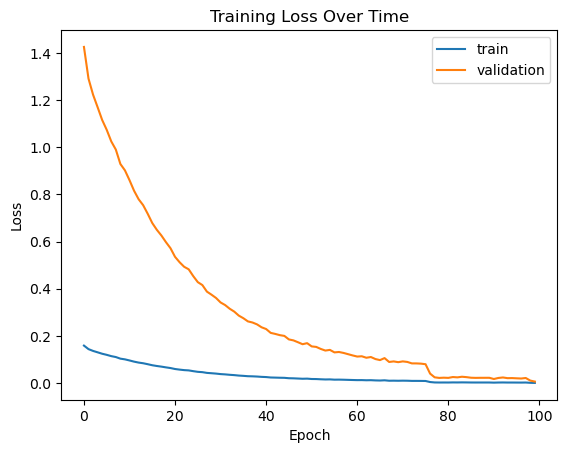

In [92]:
plt.plot(train_running_loss,label='train')
plt.plot(validation_running_loss,label='validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

##  Basic T

In [84]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
# scheduler = ReduceLROnPlateau(optimizer, 'min') to task 
criterion = nn.CrossEntropyLoss(reduction = 'none',weight=torch.tensor([0,10.,1.]).to(device))

loss_values = []
list_of_invalid  = []
epochs = 3
net.train()
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        if torch.isnan(inputs).any()  :
            print('invalid input detected at iteration ', i)
        if torch.isnan(labels).any() : 
            print('invalid labels detected at iteration ', i)
            list_of_invalid.append(labels)
            
        optimizer.zero_grad()

        outputs = net(inputs)
        labels = labels.type(torch.LongTensor).to(device)

        loss = ((criterion(outputs, labels) * (labels>0)).mean(0)).mean()

              
        loss.backward()
        optimizer.step()
    

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 20 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000}')
            running_loss = 0.0
    average_loss = running_loss / len(trainloader)
    loss_values.append(average_loss)

print('Finished Training')
    

100%|█████████████████████████████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.93s/it]

Finished Training


In [ ]:
len(loss_values)

# Testing

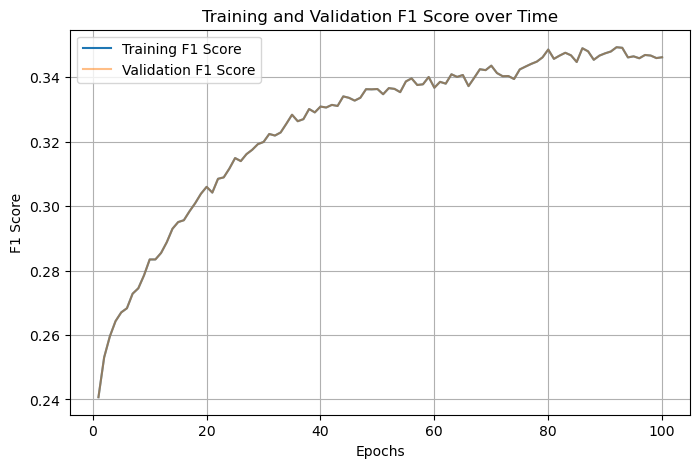

In [93]:
# plt.plot(range(1, epochs + 1), loss_values, label='Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss Over Time')
# plt.legend()
# plt.show()

# Plot the F1 score over time
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_f1_scores, label="Training F1 Score")
plt.plot(range(1, num_epochs + 1), valid_f1_scores, label="Validation F1 Score",alpha=0.5)
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("Training and Validation F1 Score over Time")
plt.legend()
plt.grid(True)
plt.show()

In [90]:

from sklearn.metrics import confusion_matrix
    
net.eval()
all_predictions = []
all_labels = []
all_input = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        outputs = torch.argmax(outputs, dim=1)
        all_predictions.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        
        
# Concatenate predictions and labels along batch dimension
predictions = np.concatenate(all_predictions)
ground_truth = np.concatenate(all_labels)

# Reshape the tensors to merge batch and class dimensions
predictions = predictions.reshape(-1, num_stations)
ground_truth = ground_truth.reshape(-1, num_stations)



Precision(Macro): 0.19566110282185825
Recall(Macro): 0.8317594944874844
Precision (Micro): 0.1738676558049269
Recall (Micro): 0.8760498071903414
Precision (Weighted): 0.17873234067762447
Recall (Weighted): 0.8760498071903414
Class 1: Precision = 0.16455959464707387, Recall = 0.91312962130806
Class 2: Precision = 0.22676261099664263, Recall = 0.7503893676669089


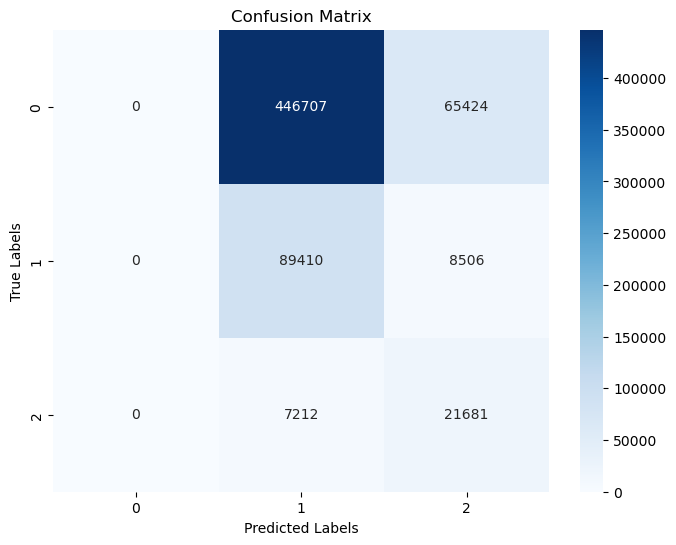

In [91]:
### import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix


predictions_flat = predictions.flatten()
ground_truth_flat = ground_truth.flatten()

precision, recall, _, _ = precision_recall_fscore_support(ground_truth_flat, predictions_flat,labels=[1,2], average='macro')


precision_micro, recall_micro, _, _ = precision_recall_fscore_support(ground_truth_flat, predictions_flat,labels=[1,2],  average='micro')


precision_weighted, recall_weighted, _, _ = precision_recall_fscore_support(ground_truth_flat, predictions_flat,labels=[1,2],  average='weighted')


precision_per_class, recall_per_class, F1, _ = precision_recall_fscore_support(ground_truth_flat, predictions_flat,labels=[1,2],  average=None)


print("Precision(Macro):", precision) #it treats all classes equally, regardless of the number of samples in each class.
print("Recall(Macro):", recall)

print("Precision (Micro):", precision_micro)
print("Recall (Micro):", recall_micro)

print("Precision (Weighted):", precision_weighted)
print("Recall (Weighted):", recall_weighted)

class_labels = [0, 1, 2]

# Display the results with class labels
for label, precision, recall in zip(class_labels, precision_per_class, recall_per_class):
    print(f"Class {label+1}: Precision = {precision}, Recall = {recall}")

confusion_mat = confusion_matrix(ground_truth_flat, predictions_flat)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Trying a FC just for reference

# Ordinal regression Functions ( didnt work properly)

In [ ]:

def coral_loss(logits, levels, importance_weights=None, reduction='mean'):
    """Computes the CORAL loss described in

    Cao, Mirjalili, and Raschka (2020)
    *Rank Consistent Ordinal Regression for Neural Networks
       with Application to Age Estimation*
    Pattern Recognition Letters, https://doi.org/10.1016/j.patrec.2020.11.008

    Parameters
    ----------
    logits : torch.tensor, shape(num_examples, num_classes-1)
        Outputs of the CORAL layer.

    levels : torch.tensor, shape(num_examples, num_classes-1)
        True labels represented as extended binary vectors
        (via `coral_pytorch.dataset.levels_from_labelbatch`).

    importance_weights : torch.tensor, shape=(num_classes-1,) (default=None)
        Optional weights for the different labels in levels.
        A tensor of ones, i.e.,
        `torch.ones(num_classes-1, dtype=torch.float32)`
        will result in uniform weights that have the same effect as None.

    reduction : str or None (default='mean')
        If 'mean' or 'sum', returns the averaged or summed loss value across
        all data points (rows) in logits. If None, returns a vector of
        shape (num_examples,)

    Returns
    ----------
        loss : torch.tensor
        A torch.tensor containing a single loss value (if `reduction='mean'` or '`sum'`)
        or a loss value for each data record (if `reduction=None`).

    Examples
    ----------
    >>> import torch
    >>> from coral_pytorch.losses import coral_loss
    >>> levels = torch.tensor(
    ...    [[1., 1., 0., 0.],
    ...     [1., 0., 0., 0.],
    ...    [1., 1., 1., 1.]])
    >>> logits = torch.tensor(
    ...    [[2.1, 1.8, -2.1, -1.8],
    ...     [1.9, -1., -1.5, -1.3],
    ...     [1.9, 1.8, 1.7, 1.6]])
    >>> coral_loss(logits, levels)
    tensor(0.6920)
    """

    if not logits.shape == levels.shape:
        raise ValueError("Please ensure that logits (%s) has the same shape as levels (%s). "
                         % (logits.shape, levels.shape))

    term1 = (F.logsigmoid(logits)*levels
                      + (F.logsigmoid(logits) - logits)*(1-levels))

    if importance_weights is not None:
        term1 *= importance_weights

    val = (-torch.sum(term1, dim=1))

    if reduction == 'mean':
        loss = torch.mean(val)
    elif reduction == 'sum':
        loss = torch.sum(val)
    elif reduction is None:
        loss = val
    else:
        s = ('Invalid value for `reduction`. Should be "mean", '
             '"sum", or None. Got %s' % reduction)
        raise ValueError(s)

    return loss


In [ ]:

class SoftOrdinalLoss(nn.Module):
    def __init__(self):
        super(SoftOrdinalLoss, self).__init__()

    def forward(self, logits, ordinal_labels):
        """
        Compute the soft ordinal classification loss (Cumulative Link Loss).

        Args:
            logits (torch.Tensor): The predicted logits from the model (shape: [batch_size, stations, num_classes]).
            ordinal_labels (torch.Tensor): The ordinal class labels as binary matrices (shape: [batch_size, stations, num_classes-1]).

        Returns:
            torch.Tensor: The calculated loss value.
        """
        batch_size, num_classes, num_stations,  = logits.size()

        # Compute the cumulative logits (z_i in the formula).
        cumulative_logits = torch.cumsum(logits, dim=1)

        # Calculate the CLL loss.
        positive_part = torch.log(1 + torch.exp(-cumulative_logits))
        negative_part = ordinal_labels * cumulative_logits
        loss = torch.sum(positive_part - negative_part) / (batch_size * num_stations)

        return loss

In [ ]:

def convert_to_ordinal_labels(class_labels, num_classes):
    """
    Convert class labels to ordinal labels (binary matrices).

    Args:
        class_labels (torch.Tensor): Tensor containing class labels (shape: [batch_size, num_stations]).
        num_classes (int): Total number of classes (for each station).

    Returns:
        torch.Tensor: Tensor containing ordinal labels (shape: [batch_size, num_stations, num_classes-1]).
    """
    batch_size, num_stations = class_labels.size()
    ordinal_labels = torch.zeros(batch_size,  num_classes - 1, num_stations)

    for i in range(batch_size):
        for j in range(num_stations):
            ordinal_labels[i, :int(class_labels[i, j].item()), j ] = 1
            
    

    return ordinal_labels


# Check Consistency 

In [ ]:

def train(model, train_loader, optimizer, loss_criterion):
    model.train()
    epochs = 3
    for epoch in range(epochs):
#         print(f' {epoch+1} / {epochs}')
        for data in train_loader:
            images, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            

            # Forward pass
            outputs = model(images)

            # Calculate the loss
            loss = loss_criterion(outputs, labels)  # Assuming inputs are the target values for autoencoder

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        
def test(model, test_loader, loss_criterion):
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
   
            # Forward pass
            outputs = model(images)
            
            # Calculate the loss
            loss = loss_criterion(outputs, labels)  # Assuming inputs are the target values for autoencoder
            test_loss += loss.item()
    
    # Calculate average test loss
    test_loss /= len(test_loader.dataset)
    return test_loss

num_seeds = 10
performance_count = 0 



for seed in tqdm(range(num_seeds)):
    # Set the random seed
    torch.manual_seed(seed)

    net = RegressionResNet(input_shape).to(device)
    
    rows_to_keep = (~greecee_stations.isnull().all(axis=1))

    # Filter tensor input and target dataframe
    filtered_input_tensor = tensor[rows_to_keep][:,:1,:,:]
    filtered_input_tensor_corrected = tensor_with_correction[rows_to_keep][:,:1,:,:]
    filtered_target_dataframe = greecee_stations[rows_to_keep]
    
    filtered_target_dataframe['time'] = pd.to_datetime(filtered_target_dataframe['time'])
    label_tensor = torch.tensor(filtered_target_dataframe.drop('time',axis=1).values, dtype=torch.float32)

    dataset1 = CustomDataset(filtered_input_tensor, filtered_target_dataframe ,label_tensor)
    dataset2 = CustomDataset(filtered_input_tensor_corrected, filtered_target_dataframe, label_tensor)


    train_dataset1, test_dataset1 = train_test_split(dataset1, test_size=0.2, random_state=seed)
    train_dataset2, test_dataset2 = train_test_split(dataset2, test_size=0.2, random_state=seed)
    
    batch_size = 32  # Set your desired batch size
    trainloader1 = DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
    testloader1 = DataLoader(test_dataset1, batch_size=batch_size, shuffle=False)
    trainloader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
    testloader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)


    
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
    criterion = IgnoringNullMSELoss()
    
    train(net, trainloader1, optimizer, criterion)
    original_metric = test(net, testloader1, criterion)

    # Train and test the model on the new dataset
    train(net, trainloader2, optimizer, criterion)
    new_metric = test(net, testloader2, criterion)
    
    
    
    print(f' new metric {new_metric}, original_metric {original_metric}')
    if new_metric < original_metric:
        performance_count += 1

# Print the number of times the new dataset outperformed the original one
print(f"New dataset outperformed the original dataset {performance_count}/{num_seeds} times.")